# Data Analysis 

## Jade Benson

In this notebook, I will be examining the descriptive statistics and running random forests for my thesis analysis. 

## Descriptive Statistics 

In [23]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import mapclassify as mc
import sklearn 
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from dtreeviz.trees import *

import statsmodels.api as sm
from statsmodels.formula.api import ols


In [2]:
no_missing_data = pd.read_pickle('no_missing_data.pkl')

In [5]:
weather_vars = ['tavg_mean', 'tmin_min', 'tmax_max', 'prcp_max', 'snow_max', 'wspd_max']    
demo_vars = ['prop_65_85_up', 'prop_female', 'prop_white_nh', 'pop_density']
econ_vars = ['median_income', 'gini_index', 'prop_poor']
full_vars = weather_vars + demo_vars + econ_vars

In [8]:
#descriptive statistics of the analytic sample 
no_missing_data[full_vars + ['scaled_fall_rate']].describe()

,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,prop_65_85_up,prop_female,prop_white_nh,pop_density,median_income,gini_index,prop_poor,scaled_fall_rate
count,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000
mean,13.727632,0.697405,27.207233,11.671616,7.761297,21.547019,0.129568,0.561835,0.859050,48.366273,25936.348480,0.445919,0.084612,157.010741
std,9.611165,11.253450,8.295228,27.130052,44.711290,7.351409,0.023939,0.018228,0.139238,151.017829,5581.851296,0.030795,0.030226,67.252725
min,-19.066667,-37.800000,-13.000000,0.000000,0.000000,0.000000,0.049210,0.469969,0.047547,0.133814,12861.000000,0.352500,0.023863,1.217505
25%,6.590000,-6.600000,22.000000,0.000000,0.000000,16.200000,0.112735,0.551216,0.807577,8.296301,22123.000000,0.425100,0.064569,114.081643
50%,14.927586,0.600000,28.900000,0.500000,0.000000,21.000000,0.129507,0.563373,0.909124,17.013867,25057.000000,0.444600,0.078996,146.949136
75%,21.686667,9.400000,33.300000,17.300000,0.000000,26.200000,0.146109,0.573519,0.958305,36.169832,28169.000000,0.464900,0.097693,185.597624
max,36.110345,26.700000,49.400000,4790.400000,914.000000,70.200000,0.238095,0.621529,1.000000,3579.175610,59876.000000,0.597500,0.339693,1190.476190


### Regional Descriptives

In [11]:
#regions key 
west = ['WA', 'OR', 'CA', 'MT', 'ID', 'WY', 'NV', 'UT', 'CO', 'AZ', 'NM']
midwest = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH']
south = ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'GA', 'FL', 'SC', 'NC', 'KY', 'TN', 'WV','MD', 'DE', 'VA', 'DC']
northeast = ['PA', 'NY', 'NJ', 'VT', 'NH', 'MA', 'CT', 'RI', 'ME']

In [28]:
#create regional dataframes 
west_region = no_missing_data[no_missing_data['region']== 'west']
print("Number of counties: ", len(west_region['fipscounty'].unique()))

midwest_region = no_missing_data[no_missing_data['region']== 'midwest']
print("Number of counties: ", len(midwest_region['fipscounty'].unique()))

south_region = no_missing_data[no_missing_data['region']== 'south']
print("Number of counties: ", len(south_region['fipscounty'].unique()))

northeast_region = no_missing_data[no_missing_data['region']== 'northeast']
print("Number of counties: ", len(northeast_region['fipscounty'].unique()))



Number of counties:  193
Number of counties:  506
Number of counties:  838
Number of counties:  196


In [29]:
#descriptive statistics for each region
west_region[full_vars + ['scaled_fall_rate']].describe()


,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,prop_65_85_up,prop_female,prop_white_nh,pop_density,median_income,gini_index,prop_poor,scaled_fall_rate
count,8476.000000,8476.000000,8476.000000,8476.000000,8476.000000,8476.000000,8476.000000,8476.000000,8476.000000,8476.000000,8476.000000,8476.000000,8476.000000,8476.000000
mean,13.061452,0.526298,27.235087,5.557916,5.838839,21.937777,0.128877,0.545897,0.809292,35.629225,26180.732185,0.445846,0.084463,113.759689
std,8.277174,9.540970,8.917378,11.813199,30.284371,8.235708,0.018702,0.016142,0.158714,115.407517,5311.962846,0.025232,0.026910,49.157242
min,-17.500000,-36.600000,-13.000000,0.000000,0.000000,0.000000,0.081226,0.476047,0.197482,0.133814,13558.000000,0.360500,0.032697,1.217505
25%,7.152500,-5.000000,20.600000,0.000000,0.000000,16.000000,0.117904,0.534107,0.694545,3.113644,22176.000000,0.428400,0.067702,80.675980
50%,13.091935,1.100000,27.800000,0.000000,0.000000,21.000000,0.128071,0.547954,0.874579,7.331895,25057.000000,0.446400,0.077653,106.061610
75%,19.079167,7.200000,34.400000,6.400000,0.000000,26.700000,0.141449,0.558168,0.936537,28.384667,29643.000000,0.462300,0.097257,137.441500
max,36.110345,26.700000,49.400000,155.500000,460.000000,58.300000,0.199125,0.581213,0.981735,1181.298402,47489.000000,0.524100,0.305495,647.439670


In [30]:
midwest_region[full_vars + ['scaled_fall_rate']].describe()


,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,prop_65_85_up,prop_female,prop_white_nh,pop_density,median_income,gini_index,prop_poor,scaled_fall_rate
count,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000
mean,10.436019,-3.496628,24.851026,10.472208,12.497064,25.011998,0.140906,0.564552,0.933132,37.494947,26301.288961,0.434089,0.071213,161.614751
std,10.443752,11.909576,9.455718,17.055039,55.618445,6.948085,0.020829,0.013340,0.070312,57.749133,4327.369881,0.027825,0.020094,60.646786
min,-19.066667,-37.800000,-8.000000,0.000000,0.000000,2.400000,0.073453,0.498342,0.483938,1.002127,12861.000000,0.352500,0.023863,31.150568
25%,1.353590,-12.800000,17.800000,0.000000,0.000000,20.100000,0.127279,0.557667,0.925786,11.495886,23194.000000,0.414600,0.056587,120.209503
50%,11.441935,-2.200000,27.800000,0.900000,0.000000,24.600000,0.142579,0.565761,0.954107,19.688021,25747.000000,0.432200,0.069830,154.229446
75%,19.810608,6.700000,32.200000,15.700000,0.000000,29.500000,0.155719,0.572306,0.974112,35.886116,28342.000000,0.449700,0.081406,191.726503
max,31.372414,22.000000,45.000000,223.400000,737.000000,70.200000,0.238095,0.606787,1.000000,407.662860,42133.000000,0.535200,0.175256,1190.476190


In [31]:
south_region[full_vars + ['scaled_fall_rate']].describe()


,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,prop_65_85_up,prop_female,prop_white_nh,pop_density,median_income,gini_index,prop_poor,scaled_fall_rate
count,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000
mean,16.912792,4.216770,29.576804,14.004474,3.346263,19.453879,0.117606,0.563348,0.816525,35.911582,24752.689391,0.453495,0.095304,170.161716
std,8.340665,10.244877,6.305583,35.450225,26.175320,6.574003,0.021707,0.019216,0.145999,73.917362,5929.715455,0.032183,0.032728,75.392864
min,-7.289286,-32.800000,2.000000,0.000000,0.000000,0.000000,0.049210,0.469969,0.047547,1.307995,13148.000000,0.360000,0.027206,23.753439
25%,9.982759,-3.800000,25.000000,0.000000,0.000000,14.800000,0.103233,0.551618,0.755675,7.531875,21013.000000,0.432600,0.073839,122.783083
50%,18.050000,3.300000,30.600000,0.500000,0.000000,19.000000,0.116576,0.564516,0.845847,14.311177,23453.000000,0.452900,0.088894,155.026742
75%,24.268966,13.000000,34.400000,22.100000,0.000000,23.700000,0.131688,0.575641,0.925449,28.186392,26728.000000,0.474500,0.112188,197.954470
max,34.629032,26.100000,48.000000,4790.400000,864.000000,58.000000,0.213159,0.621529,0.995347,788.461538,59876.000000,0.561800,0.339693,1051.625239


In [32]:
northeast_region[full_vars + ['scaled_fall_rate']].describe()


,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,prop_65_85_up,prop_female,prop_white_nh,pop_density,median_income,gini_index,prop_poor,scaled_fall_rate
count,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000
mean,10.217088,-2.717386,24.011946,11.699090,14.674056,21.724492,0.147074,0.565858,0.903858,114.220769,28672.864472,0.442989,0.075032,145.447775
std,9.558306,10.837183,8.744558,18.928123,69.668059,7.176474,0.018548,0.017133,0.119644,331.412328,5507.408550,0.028620,0.026712,44.272336
min,-16.213043,-36.700000,-10.000000,0.000000,0.000000,3.500000,0.085763,0.512253,0.239089,0.863197,19553.000000,0.366000,0.033884,31.949173
25%,1.793161,-10.600000,17.000000,0.000000,0.000000,16.500000,0.133638,0.555434,0.875616,15.336536,24331.750000,0.422900,0.058475,116.951865
50%,10.967143,-2.000000,26.100000,1.500000,0.000000,21.200000,0.148174,0.568167,0.950331,30.686288,27360.000000,0.438800,0.071534,144.808612
75%,18.796774,6.700000,31.600000,18.500000,0.000000,26.400000,0.159925,0.578116,0.976307,72.361863,31669.000000,0.455600,0.082916,171.465614
max,31.857143,23.300000,42.200000,203.700000,914.000000,58.300000,0.206245,0.617178,0.994908,3579.175610,45469.000000,0.597500,0.227895,509.482027


In [42]:
#perform two-way ANOVA
# https://www.statsmodels.org/dev/generated/statsmodels.stats.anova.anova_lm.html

model = ols('scaled_fall_rate ~ C(region)', data=no_missing_data).fit()
table = sm.stats.anova_lm(model, typ=2)
print(table)

                 sum_sq       df           F  PR(>F)
C(region)  2.295178e+07      3.0  1830.16877     0.0
Residual   2.798312e+08  66941.0         NaN     NaN


In [47]:
for v in full_vars: 
    formula = str(v) + ' ~ C(region)'
    model = ols(formula, data=no_missing_data).fit()
    table = sm.stats.anova_lm(model, typ=2)
    print("ANOVA for: " , v)
    print(table)

ANOVA for:  tavg_mean
                 sum_sq       df            F  PR(>F)
C(region)  6.313107e+05      3.0  2536.980552     0.0
Residual   5.552607e+06  66941.0          NaN     NaN
ANOVA for:  tmin_min
                 sum_sq       df            F  PR(>F)
C(region)  8.064747e+05      3.0  2345.802628     0.0
Residual   7.671322e+06  66941.0          NaN     NaN
ANOVA for:  tmax_max
                 sum_sq       df            F  PR(>F)
C(region)  3.746820e+05      3.0  1975.649295     0.0
Residual   4.231788e+06  66941.0          NaN     NaN
ANOVA for:  prcp_max
                 sum_sq       df           F         PR(>F)
C(region)  5.099265e+05      3.0  233.336955  1.278505e-150
Residual   4.876352e+07  66941.0         NaN            NaN
ANOVA for:  snow_max
                 sum_sq       df           F         PR(>F)
C(region)  1.513799e+06      3.0  255.289845  9.545967e-165
Residual   1.323139e+08  66941.0         NaN            NaN
ANOVA for:  wspd_max
                 sum_sq    

## Age-sex-race-ses adjustment 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3406211/?_gl=1*advzek*_ga*MTA3MDE3OTkwNS4xNjM2MDY1NDg3*_ga_7147EPK006*MTY1MDg5ODU2OS4yLjEuMTY1MDg5ODU3OS4w*_ga_P1FPTH9PL4*MTY1MDg5ODU2OS4yLjEuMTY1MDg5ODU3OS4w

In [69]:
#use the full df since it has populations for every county which is really important 
age_sex_poverty = pd.read_csv('age_sex_poverty.csv')


In [70]:
age_sex_poverty.head()

,Unnamed: 0,GEOID,poverty_65_74,poverty_75_up,men_65_74,men_75_up,women_65_74,women_75_up,pop_65_74,pop_75_up,...,prop_men_75_up,prop_women_75_up,poor_men_65_74,notpoor_men_65_74,poor_men_75_up,notpoor_men_75_up,poor_women_65_74,notpoor_women_65_74,poor_women_75_up,notpoor_women_75_up
0,1,1001,383,112,1967,1128,2594,1632,4561,2760,...,0.408696,0.591304,165.174523,1801.825477,45.773913,1082.226087,217.825477,2376.174523,66.226087,1565.773913
1,2,1003,999,1212,9493,6181,10478,7630,19971,13811,...,0.447542,0.552458,474.863903,9018.136097,542.420679,5638.579321,524.136097,9953.863903,669.579321,6960.420679
2,3,1005,395,233,1166,635,1324,1055,2490,1690,...,0.375740,0.624260,184.967871,981.032129,87.547337,547.452663,210.032129,1113.967871,145.452663,909.547337
3,4,1007,245,107,976,468,943,822,1919,1290,...,0.362791,0.637209,124.606566,851.393434,38.818605,429.181395,120.393434,822.606566,68.181395,753.818605
4,5,1009,472,378,2600,1486,2974,2112,5574,3598,...,0.413007,0.586993,220.165052,2379.834948,156.116732,1329.883268,251.834948,2722.165052,221.883268,1890.116732


In [81]:
age_sex_poverty['total_pop'] = age_sex_poverty['pop_65_74'] + age_sex_poverty['pop_75_up']

In [82]:
age_sex_poverty.columns

Index(['Unnamed: 0', 'GEOID', 'poverty_65_74', 'poverty_75_up', 'men_65_74',
       'men_75_up', 'women_65_74', 'women_75_up', 'pop_65_74', 'pop_75_up',
       'prop_men_65_74', 'prop_women_65_74', 'prop_men_75_up',
       'prop_women_75_up', 'poor_men_65_74', 'notpoor_men_65_74',
       'poor_men_75_up', 'notpoor_men_75_up', 'poor_women_65_74',
       'notpoor_women_65_74', 'poor_women_75_up', 'notpoor_women_75_up',
       'total_pop'],
      dtype='object')

In [83]:
#get standard population values 
#sums for each category, round

total_poor_men_65_74 = round(age_sex_poverty['poor_men_65_74'].sum()) 
total_notpoor_men_65_74 = round(age_sex_poverty['notpoor_men_65_74'].sum())
total_poor_men_75_up = round(age_sex_poverty['poor_men_75_up'].sum())
total_notpoor_men_75_up = round(age_sex_poverty['notpoor_men_75_up'].sum())


total_poor_women_65_74 = round(age_sex_poverty['poor_women_65_74'].sum())
total_notpoor_women_65_74 = round(age_sex_poverty['notpoor_women_65_74'].sum())
total_poor_women_75_up = round(age_sex_poverty['poor_women_75_up'].sum())
total_notpoor_women_75_up = round(age_sex_poverty['notpoor_women_75_up'].sum()) 

total_population = age_sex_poverty['total_pop'].sum()
print(total_population)


43760091


In [84]:
#merge in with the non missing data 
adjusted_df = no_missing_data.merge(age_sex_poverty, how = 'inner',  left_on = 'fipscounty', right_on = 'GEOID')
adjusted_df.head()

,month_count,fipscounty,date,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,median_income,...,prop_women_75_up,poor_men_65_74,notpoor_men_65_74,poor_men_75_up,notpoor_men_75_up,poor_women_65_74,notpoor_women_65_74,poor_women_75_up,notpoor_women_75_up,total_pop
0,14.0,1001.0,2011-01,5.823333,-8.0,23.0,0.0,0.0,16.8,26728.0,...,0.591304,165.174523,1801.825477,45.773913,1082.226087,217.825477,2376.174523,66.226087,1565.773913,7321
1,12.0,1001.0,2010-02,6.296154,-4.4,21.6,0.0,0.0,16.0,26728.0,...,0.591304,165.174523,1801.825477,45.773913,1082.226087,217.825477,2376.174523,66.226087,1565.773913,7321
2,12.0,1001.0,2012-02,12.468966,-4.5,25.6,0.0,0.0,22.2,26728.0,...,0.591304,165.174523,1801.825477,45.773913,1082.226087,217.825477,2376.174523,66.226087,1565.773913,7321
3,12.0,1001.0,2013-02,10.213333,-2.3,22.4,0.0,0.0,12.9,26728.0,...,0.591304,165.174523,1801.825477,45.773913,1082.226087,217.825477,2376.174523,66.226087,1565.773913,7321
4,12.0,1001.0,2015-02,6.696000,-6.1,20.2,0.0,0.0,19.2,26728.0,...,0.591304,165.174523,1801.825477,45.773913,1082.226087,217.825477,2376.174523,66.226087,1565.773913,7321


In [85]:
adjusted_df['num_falls_poor_men_65_74'] = adjusted_df['month_count'] * (adjusted_df['poor_men_65_74'] / adjusted_df['total_pop'])

In [87]:
adjusted_df['rate_poor_men_65_74'] = adjusted_df['num_falls_poor_men_65_74'] / adjusted_df['poor_men_65_74']
#total fall rate and strata specific are the same 

In [90]:
adjusted_df['scaled_fall_rate']

0        191.230706
1        163.912034
2        163.912034
3        163.912034
4        163.912034
            ...    
66940    222.177338
66941    242.375278
66942    222.177338
66943    262.573218
66944    222.177338
Name: scaled_fall_rate, Length: 66945, dtype: float64

In [92]:
adjusted_df['rate_poor_men_65_74']

0        0.001912
1        0.001639
2        0.001639
3        0.001639
4        0.001639
           ...   
66940    0.002222
66941    0.002424
66942    0.002222
66943    0.002626
66944    0.002222
Name: rate_poor_men_65_74, Length: 66945, dtype: float64

In [93]:
adjusted_df['estimated_poor_men_65_74'] = adjusted_df['rate_poor_men_65_74'] * total_poor_men_65_74

In [94]:
#men
adjusted_df['num_falls_poor_men_75_up'] = adjusted_df['month_count'] * (adjusted_df['poor_men_75_up'] / adjusted_df['total_pop'])
adjusted_df['rate_poor_men_75_up'] = adjusted_df['num_falls_poor_men_75_up'] / adjusted_df['poor_men_75_up']
adjusted_df['estimated_poor_men_75_up'] = adjusted_df['rate_poor_men_75_up'] * total_poor_men_75_up

adjusted_df['num_falls_notpoor_men_65_74'] = adjusted_df['month_count'] * (adjusted_df['notpoor_men_65_74'] / adjusted_df['total_pop'])
adjusted_df['rate_notpoor_men_65_74'] = adjusted_df['num_falls_notpoor_men_65_74'] / adjusted_df['notpoor_men_65_74']
adjusted_df['estimated_notpoor_men_65_74'] = adjusted_df['rate_notpoor_men_65_74'] * total_notpoor_men_65_74

adjusted_df['num_falls_notpoor_men_75_up'] = adjusted_df['month_count'] * (adjusted_df['notpoor_men_75_up'] / adjusted_df['total_pop'])
adjusted_df['rate_notpoor_men_75_up'] = adjusted_df['num_falls_notpoor_men_75_up'] / adjusted_df['notpoor_men_75_up']
adjusted_df['estimated_notpoor_men_75_up'] = adjusted_df['rate_notpoor_men_75_up'] * total_notpoor_men_75_up


#women
adjusted_df['num_falls_poor_women_65_74'] = adjusted_df['month_count'] * (adjusted_df['poor_women_65_74'] / adjusted_df['total_pop'])
adjusted_df['rate_poor_women_65_74'] = adjusted_df['num_falls_poor_women_65_74'] / adjusted_df['poor_women_65_74']
adjusted_df['estimated_poor_women_65_74'] = adjusted_df['rate_poor_women_65_74'] * total_poor_women_65_74

adjusted_df['num_falls_poor_women_75_up'] = adjusted_df['month_count'] * (adjusted_df['poor_women_75_up'] / adjusted_df['total_pop'])
adjusted_df['rate_poor_women_75_up'] = adjusted_df['num_falls_poor_women_75_up'] / adjusted_df['poor_women_75_up']
adjusted_df['estimated_poor_women_75_up'] = adjusted_df['rate_poor_women_75_up'] * total_poor_women_75_up

adjusted_df['num_falls_notpoor_women_65_74'] = adjusted_df['month_count'] * (adjusted_df['notpoor_women_65_74'] / adjusted_df['total_pop'])
adjusted_df['rate_notpoor_women_65_74'] = adjusted_df['num_falls_notpoor_women_65_74'] / adjusted_df['notpoor_women_65_74']
adjusted_df['estimated_notpoor_women_65_74'] = adjusted_df['rate_notpoor_women_65_74'] * total_notpoor_women_65_74

adjusted_df['num_falls_notpoor_women_75_up'] = adjusted_df['month_count'] * (adjusted_df['notpoor_women_75_up'] / adjusted_df['total_pop'])
adjusted_df['rate_notpoor_women_75_up'] = adjusted_df['num_falls_notpoor_women_75_up'] / adjusted_df['notpoor_women_75_up']
adjusted_df['estimated_notpoor_women_75_up'] = adjusted_df['rate_notpoor_women_75_up'] * total_notpoor_women_75_up


In [96]:
adjusted_df['strata_sum'] = adjusted_df['estimated_poor_men_65_74'] + adjusted_df['estimated_poor_men_75_up'] + adjusted_df['estimated_notpoor_men_65_74'] + adjusted_df['estimated_notpoor_men_75_up'] + adjusted_df['estimated_poor_women_65_74'] + adjusted_df['estimated_poor_women_75_up'] + adjusted_df['estimated_notpoor_women_65_74'] + adjusted_df['estimated_notpoor_women_75_up']

In [97]:
adjusted_df['adjusted_rates'] = adjusted_df['strata_sum'] / total_population

In [98]:
adjusted_df['adjusted_rates']

0        0.001912
1        0.001639
2        0.001639
3        0.001639
4        0.001639
           ...   
66940    0.002222
66941    0.002424
66942    0.002222
66943    0.002626
66944    0.002222
Name: adjusted_rates, Length: 66945, dtype: float64

In [99]:
adjusted_df['scaled_fall_rate']

0        191.230706
1        163.912034
2        163.912034
3        163.912034
4        163.912034
            ...    
66940    222.177338
66941    242.375278
66942    222.177338
66943    262.573218
66944    222.177338
Name: scaled_fall_rate, Length: 66945, dtype: float64

# Random Forest Modelling

In [790]:
#want to take out a year's worth of observations to predict that instead, set index to datetime
#this allows us to perform cross validation while perserving the timeseries structure 
no_missing_data = pd.read_pickle('no_missing_data.pkl')
no_missing_data['date'] = pd.to_datetime(no_missing_data['date'])
time_df = no_missing_data.set_index('date')

In [793]:
no_missing_data.describe()

,fipscounty,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor,pop_density,scaled_fall_rate,month
count,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,6.694500e+04,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000
mean,30428.904369,13.727632,0.697405,27.207233,11.671616,7.761297,21.547019,25936.348480,0.445919,3.726828e+04,0.129568,0.561835,0.859050,0.084612,48.366273,157.010741,6.505206
std,15495.299891,9.611165,11.253450,8.295228,27.130052,44.711290,7.351409,5581.851296,0.030795,7.429048e+04,0.023939,0.018228,0.139238,0.030226,151.017829,67.252725,3.439331
min,1001.000000,-19.066667,-37.800000,-13.000000,0.000000,0.000000,0.000000,12861.000000,0.352500,1.008000e+03,0.049210,0.469969,0.047547,0.023863,0.133814,1.217505,1.000000
25%,18005.000000,6.590000,-6.600000,22.000000,0.000000,0.000000,16.200000,22123.000000,0.425100,1.022800e+04,0.112735,0.551216,0.807577,0.064569,8.296301,114.081643,4.000000
50%,33003.000000,14.927586,0.600000,28.900000,0.500000,0.000000,21.000000,25057.000000,0.444600,1.644500e+04,0.129507,0.563373,0.909124,0.078996,17.013867,146.949136,7.000000
75%,42121.000000,21.686667,9.400000,33.300000,17.300000,0.000000,26.200000,28169.000000,0.464900,3.633400e+04,0.146109,0.573519,0.958305,0.097693,36.169832,185.597624,9.000000
max,56033.000000,36.110345,26.700000,49.400000,4790.400000,914.000000,70.200000,59876.000000,0.597500,1.149893e+06,0.238095,0.621529,1.000000,0.339693,3579.175610,1190.476190,12.000000


In [791]:
time_df.head()

,fipscounty,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor,pop_density,scaled_fall_rate,month
date,,,,,,,,,,,,,,,,,
2011-01-01,1001,5.823333,-8.0,23.0,0.0,0.0,16.8,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,191.230706,1
2010-02-01,1001,6.296154,-4.4,21.6,0.0,0.0,16.0,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,163.912034,2
2012-02-01,1001,12.468966,-4.5,25.6,0.0,0.0,22.2,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,163.912034,2
2013-02-01,1001,10.213333,-2.3,22.4,0.0,0.0,12.9,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,163.912034,2
2015-02-01,1001,6.696000,-6.1,20.2,0.0,0.0,19.2,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,163.912034,2


In [269]:
time_df.isnull().sum()

tavg_mean           0
tmin_min            0
tmax_max            0
prcp_mean           0
snow_max            0
wspd_max            0
median_income       0
gini_index          0
pop_65_up           0
prop_65_85_up       0
prop_female         0
prop_white_nh       0
prop_poor           0
pop_density         0
scaled_fall_rate    0
dtype: int64

## Weather Decision Tree

https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9


https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1 


In [921]:
def analysis_pipeline(model_type, hyperparam_grid, scoring_metric, train_x, train_y, test_x, test_y):
    """
    Pipeline for the decision tree/random forest pipeline (could be expanded)
    model_type is either "DT" or "RF" 
    Prints accuracy metrics for train/test sets and DT or features importance 
    Returns the best model 
    """
    
    if model_type == 'DT': 
        model = DecisionTreeRegressor(random_state =42)
    
    if model_type == 'RF': 
        model = RandomForestRegressor(random_state =42)
    
    
    tscv = TimeSeriesSplit(n_splits=4)
    
    grid_metric = 'neg_' + scoring_metric

    grid_search = GridSearchCV(estimator=model, cv=tscv, param_grid=hyperparam_grid, scoring = grid_metric)

    grid_search.fit(train_x, train_y)
    
    print("Best Parameters for Model: ", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    #print('Best : ', best_model)   
    
    #train error
    best_score = grid_search.best_score_
    print('Train Error is: ', best_score)
    
    #test error
    y_pred = best_model.predict(test_x)
    
    #can adjust this for different error metrics 
    if scoring_metric == 'mean_absolute_percentage_error':
        print("Test Error is: %.4f" % metrics.mean_absolute_percentage_error(test_y, y_pred))
    
    if scoring_metric == 'mean_absolute_error':
        print("Test Error is: %.4f" % metrics.mean_absolute_error(test_y, y_pred))
        
    if scoring_metric == 'mean_squared_error':
        print("Test Error is: %.4f" % metrics.mean_squared_error(test_y, y_pred,squared = True))
    
    if scoring_metric == 'root_mean_squared_error':
        print("Test Error is: %.4f" % metrics.mean_squared_error(test_y, y_pred, squared = False))
        
        
        
    
    if model_type == 'DT':
        DT_figure = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(best_model, feature_names=train_x.columns, filled=True)
    
    if model_type == 'RF': 
        
        #print one tree
        one_tree = best_model.estimators_[2]
        
        DT_figure = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(one_tree, feature_names=train_x.columns, filled=True)
        
        imp = best_model.feature_importances_

        features = train_x.columns
        
        for i in range(len(imp)): 
            print("Feature: ", features[i], "Importantance: ", imp[i])


        indices = np.argsort(imp)

        plt.figure(figsize=(7,7))
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), imp[indices], color='black', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
        
        
    
    return best_model

In [758]:
weather_vars = ['tavg_mean', 'tmin_min', 'tmax_max', 'prcp_max', 'snow_max', 'wspd_max']    
demo_vars = ['prop_65_85_up', 'prop_female', 'prop_white_nh', 'pop_density']
econ_vars = ['median_income', 'gini_index', 'prop_poor']
full_vars = weather_vars + demo_vars + econ_vars

In [694]:
def train_test_split(time_df, var_list, extras):
    """
    Takes a time_df and list of columns to remove, creates list of dataframes with train/test split (x & y sets)
    """
    
    full_var_list = var_list + extras
    x_set_vars = time_df[full_var_list]
    print(len(x_set_vars))

    X_train = x_set_vars.loc[:'2013']
    print("Length Training Set: ", len(X_train))
    print("Training Set Ratio: ", len(X_train)/len(x_set_vars))

    y_train = time_df.loc[:'2013', 'scaled_fall_rate']

    X_test = x_set_vars.loc['2014':, : ]
    print("Length Testing Set: ", len(X_test))
    print("Testing Set Ratio: ", len(X_test)/len(x_set_vars))

    y_test = time_df.loc['2014':, 'scaled_fall_rate']
    
    return([X_train, y_train, X_test, y_test])

In [697]:
rf_param_search = { 
    "max_depth": [2, 3, 4, 5],
    "min_samples_leaf": [1, 5, 10],  
    'n_estimators': [50, 100, 200]
}

66945
Length Training Set:  48938
Training Set Ratio:  0.7310179998506237
Length Testing Set:  18007
Testing Set Ratio:  0.26898200014937634
Best Parameters for Model:  {'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 100}
Train Error is:  -0.3403193197732623
Test Error is: 0.4083
Feature:  tavg_mean Importantance:  0.03635915494069994
Feature:  tmin_min Importantance:  0.4653938799943829
Feature:  tmax_max Importantance:  0.49674528137090596
Feature:  prcp_max Importantance:  0.0
Feature:  snow_max Importantance:  0.0015016836940111794
Feature:  wspd_max Importantance:  0.0


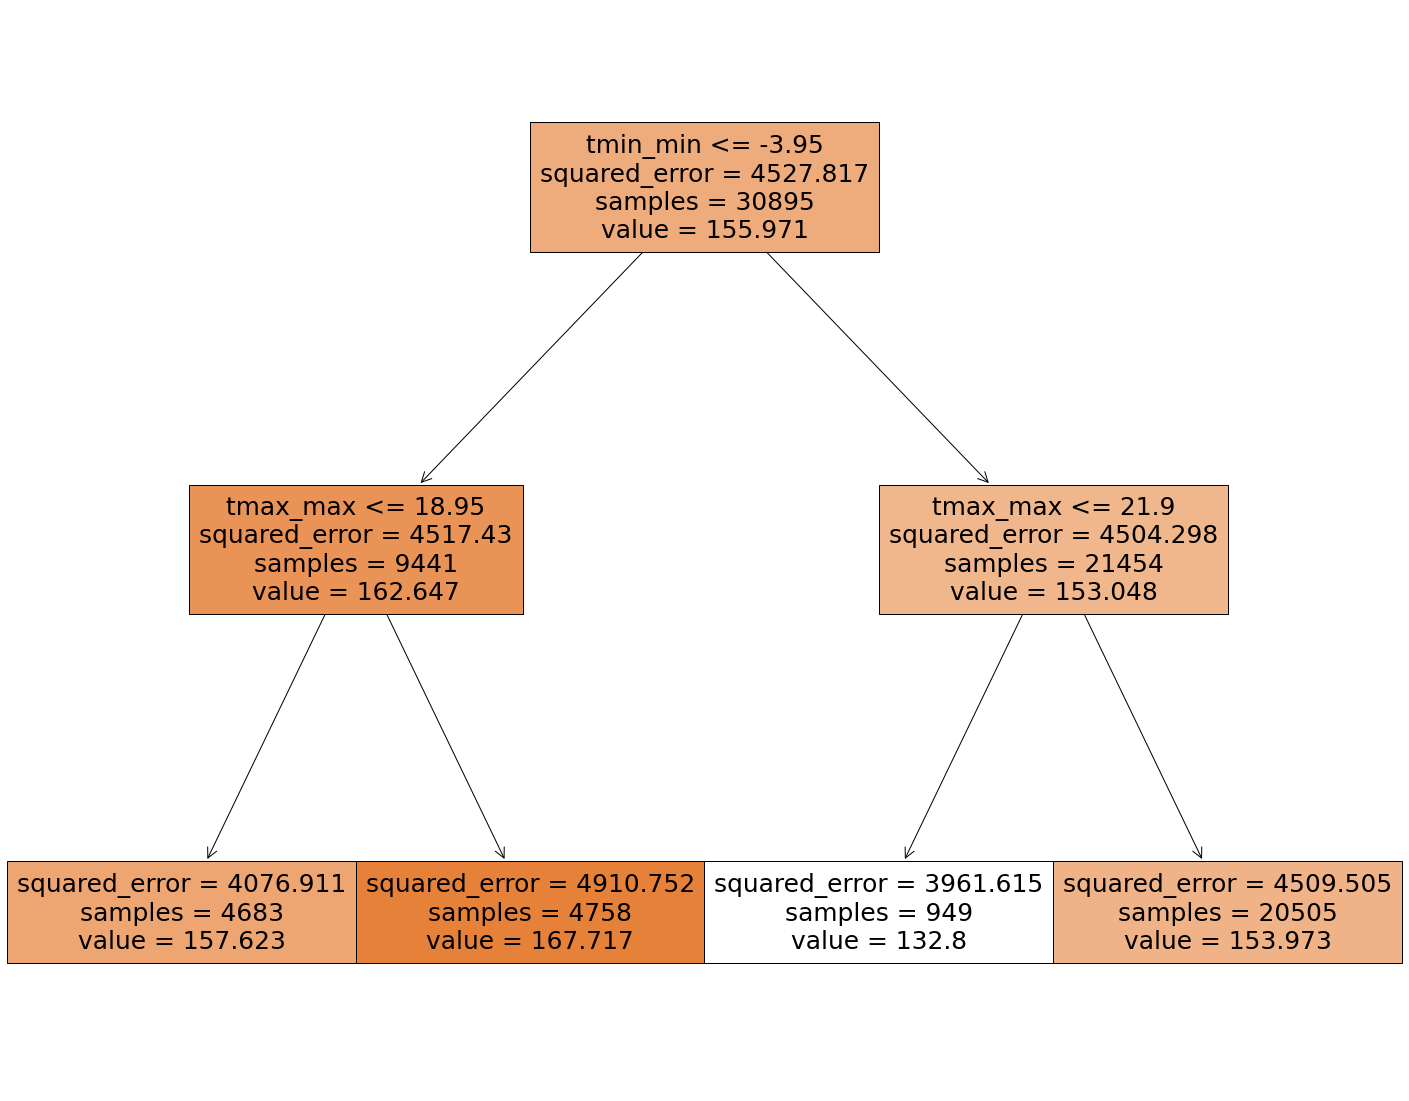

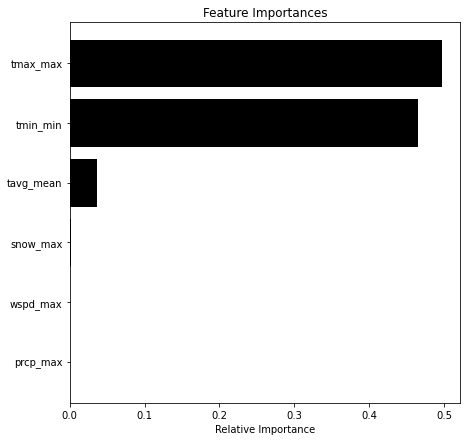

In [944]:
#could I put the region in as a categorical variable? 
#shapely package - look into this 
#use space and time to diaganose 


weather_results = train_test_split(time_df, weather_vars, [])
weather_X_train = weather_results[0]
weather_y_train = weather_results[1]
weather_X_test = weather_results[2]
weather_y_test = weather_results[3]

weather_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', weather_X_train, weather_y_train, weather_X_test, weather_y_test)


## Demographics

In [909]:
#Demogaphics training/test set 
demo_results = train_test_split(time_df, demo_vars, [])
demo_X_train = demo_results[0]
demo_y_train = demo_results[1]
demo_X_test = demo_results[2]
demo_y_test = demo_results[3]

66945
Length Training Set:  48938
Training Set Ratio:  0.7310179998506237
Length Testing Set:  18007
Testing Set Ratio:  0.26898200014937634


Best Parameters for Model:  {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 200}
Train Error is:  -0.3222595666871898
Test Error is: 0.3817
Feature:  prop_65_85_up Importantance:  0.0
Feature:  prop_female Importantance:  0.49660302489355485
Feature:  prop_white_nh Importantance:  0.0
Feature:  pop_density Importantance:  0.5033969751064452


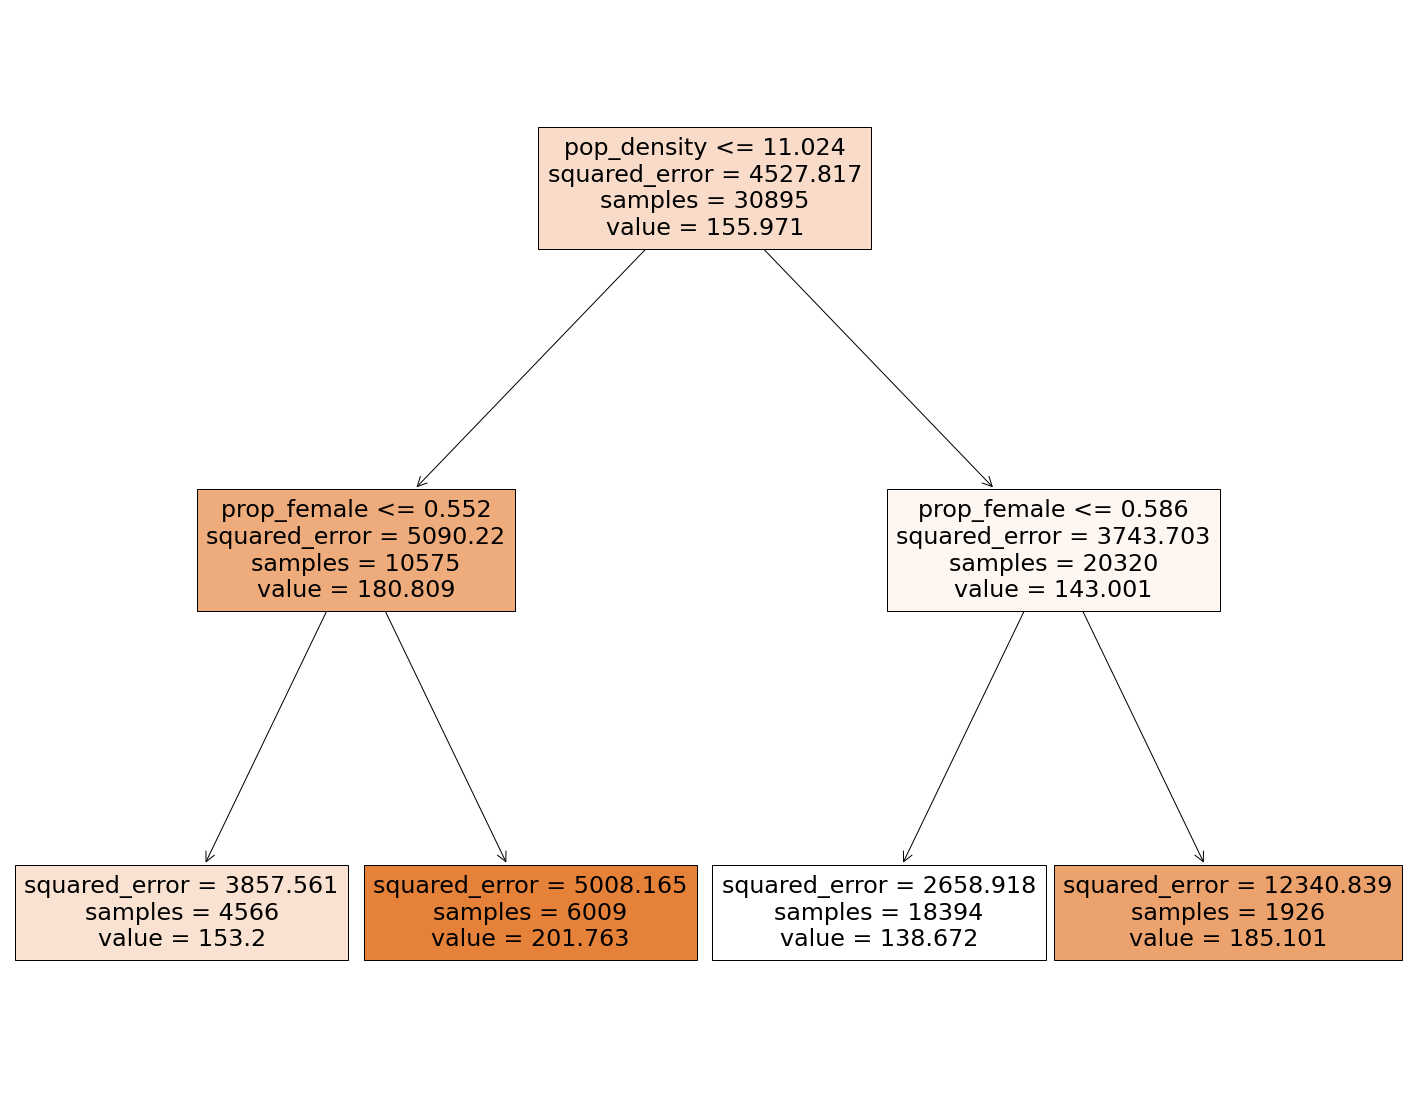

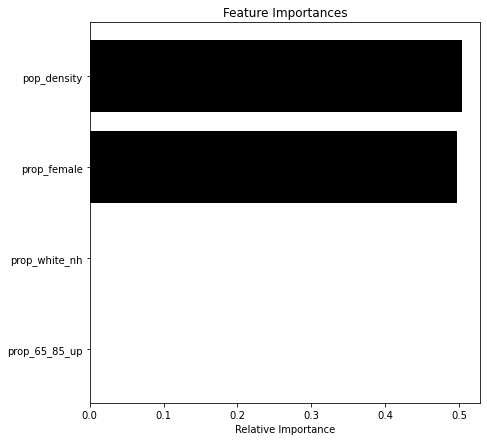

In [922]:
demo_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', demo_X_train, demo_y_train, demo_X_test, demo_y_test )

## Socioeconomic

In [982]:
#SES training/test set 
econ_results = train_test_split(time_df, econ_vars, [])
econ_X_train = econ_results[0]
econ_y_train = econ_results[1]
econ_X_test = econ_results[2]
econ_y_test = econ_results[3]

66945
Length Training Set:  48938
Training Set Ratio:  0.7310179998506237
Length Testing Set:  18007
Testing Set Ratio:  0.26898200014937634


Best Parameters for Model:  {'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 50}
Train Error is:  -0.3330708044252738
Test Error is: 0.3985
Feature:  median_income Importantance:  1.0
Feature:  gini_index Importantance:  0.0
Feature:  prop_poor Importantance:  0.0


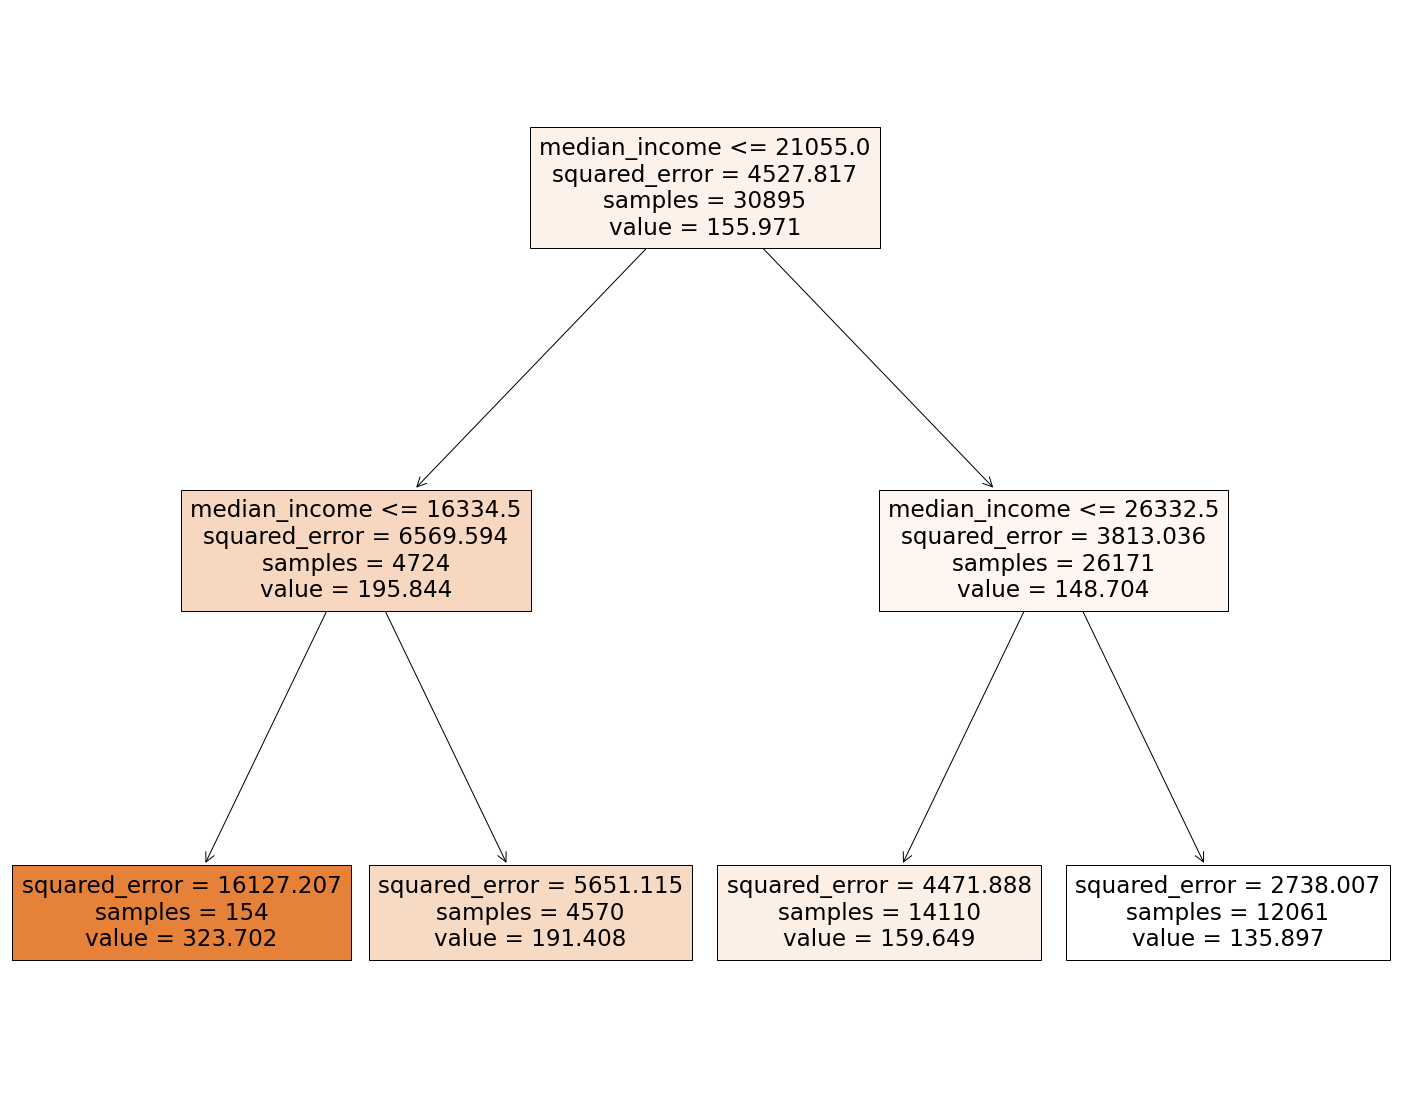

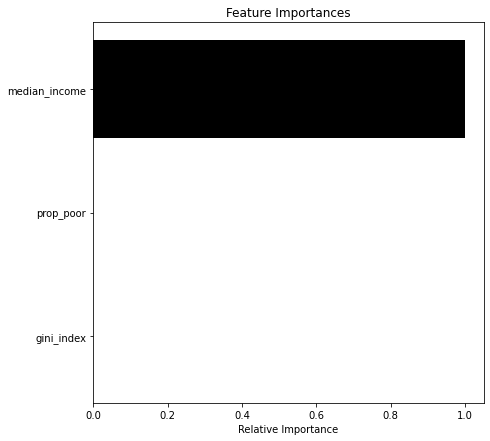

In [983]:
econ_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', econ_X_train, econ_y_train, econ_X_test, econ_y_test )

## Full Model

In [986]:
#Training/test set 
full_vars = demo_vars + econ_vars + weather_vars

#get rid of raw pop 65 and up too since this is denominator for outcome
full_results = train_test_split(time_df, full_vars, [])
full_X_train = full_results[0]
full_y_train = full_results[1]
full_X_test = full_results[2]
full_y_test = full_results[3]

66945
Length Training Set:  48938
Training Set Ratio:  0.7310179998506237
Length Testing Set:  18007
Testing Set Ratio:  0.26898200014937634


Best Parameters for Model:  {'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 200}
Train Error is:  -0.3209015187085704
Test Error is: 0.3358
Feature:  prop_65_85_up Importantance:  0.004791900946907354
Feature:  prop_female Importantance:  0.3503308881436178
Feature:  prop_white_nh Importantance:  0.21645196866541047
Feature:  pop_density Importantance:  0.3260981196995309
Feature:  median_income Importantance:  0.08659480283487532
Feature:  gini_index Importantance:  0.009939899574042895
Feature:  prop_poor Importantance:  0.005792420135615215
Feature:  tavg_mean Importantance:  0.0
Feature:  tmin_min Importantance:  0.0
Feature:  tmax_max Importantance:  0.0
Feature:  prcp_max Importantance:  0.0
Feature:  snow_max Importantance:  0.0
Feature:  wspd_max Importantance:  0.0


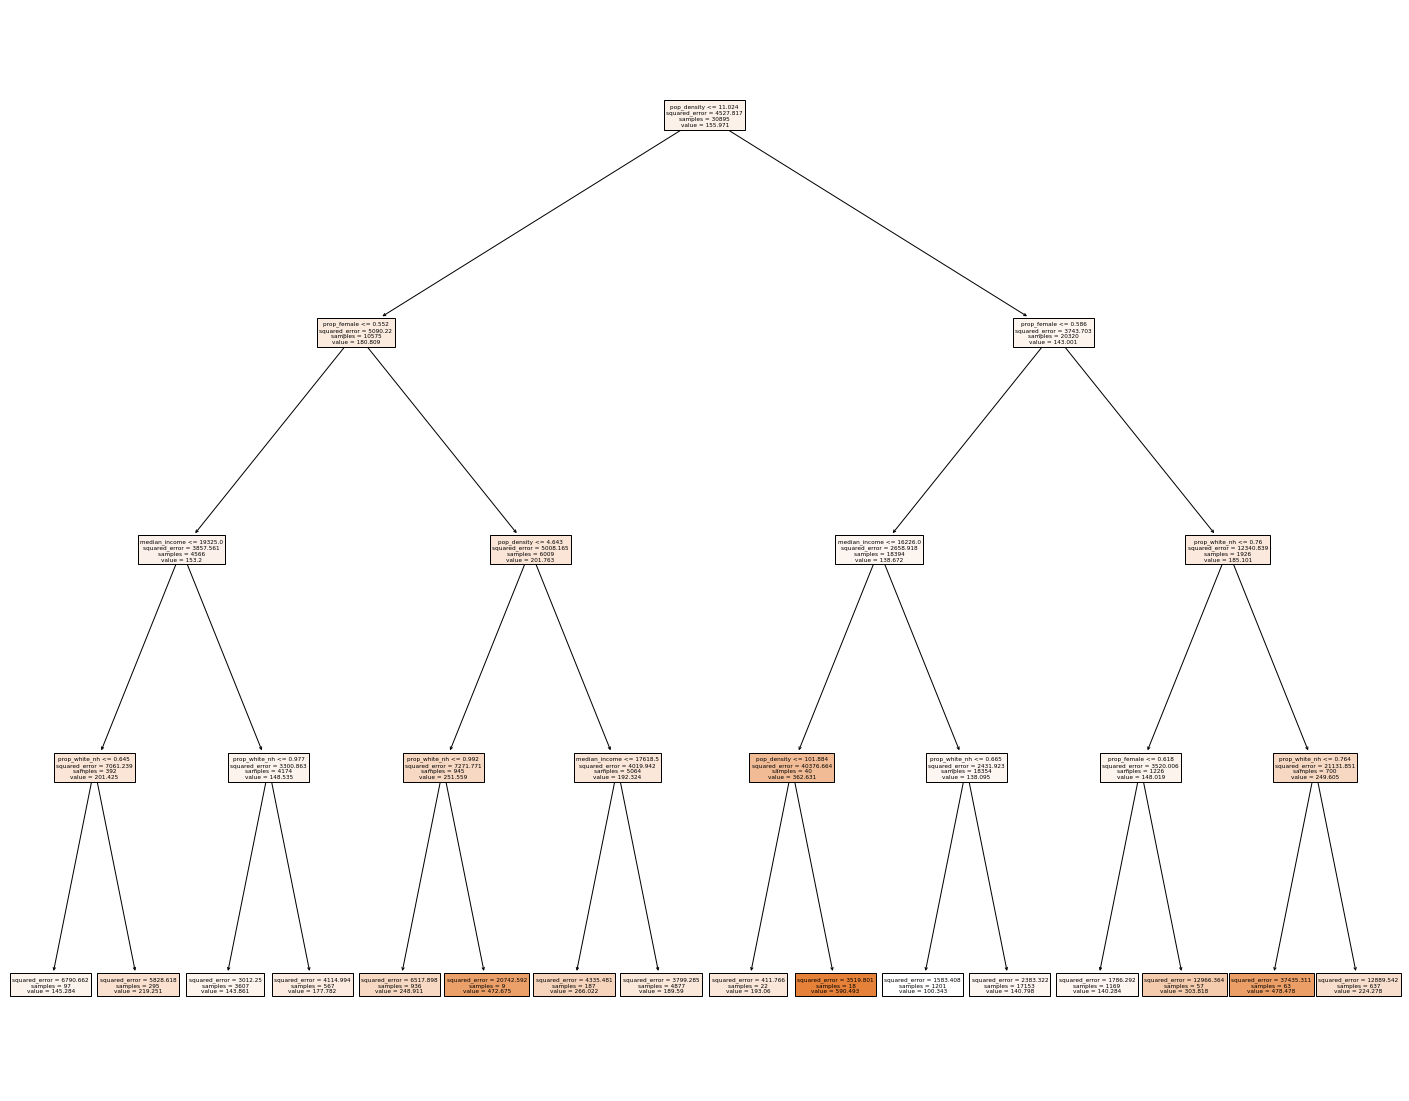

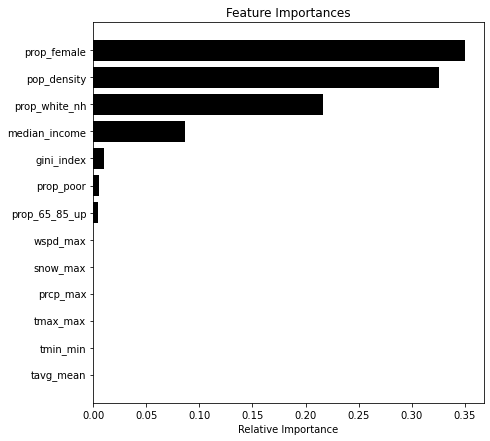

In [987]:
full_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', full_X_train, full_y_train, full_X_test, full_y_test )

In [953]:
test_preds = weather_y_test.reset_index()

In [954]:
len(test_preds)

18007

In [938]:
test_preds.head()

,date,scaled_fall_rate
0,2015-02-01 00:00:00,163.912034
1,2014-03-01 00:00:00,163.912034
2,2015-04-01 00:00:00,163.912034
3,2015-05-01 00:00:00,150.252698
4,2015-06-01 00:00:00,163.912034


In [1009]:
#predictions from all the models 
weather_pred = weather_rf.predict(weather_X_test)
demo_pred = demo_rf.predict(demo_X_test)
econ_pred = econ_rf.predict(econ_X_test)
full_pred = full_rf.predict(full_X_test)

In [1010]:
pred_df = pd.DataFrame(weather_pred, columns = ['pred'])
len(pred_df)

18007

In [1012]:
test_preds['weather_pred'] = weather_pred.tolist()
test_preds['demo_pred'] = demo_pred.tolist()
test_preds['econ_pred'] = econ_pred.tolist()
test_preds['full_pred'] = full_pred.tolist()


In [1013]:
test_preds.head()

,date,scaled_fall_rate,pred,weather_pred,demo_pred,econ_pred,full_pred
0,2015-02-01,163.912034,164.395326,164.395326,202.933961,136.433322,190.123583
1,2014-03-01,163.912034,153.079330,153.079330,202.933961,136.433322,190.123583
2,2015-04-01,163.912034,154.302105,154.302105,202.933961,136.433322,190.123583
3,2015-05-01,150.252698,154.302105,154.302105,202.933961,136.433322,190.123583
4,2015-06-01,163.912034,154.302105,154.302105,202.933961,136.433322,190.123583


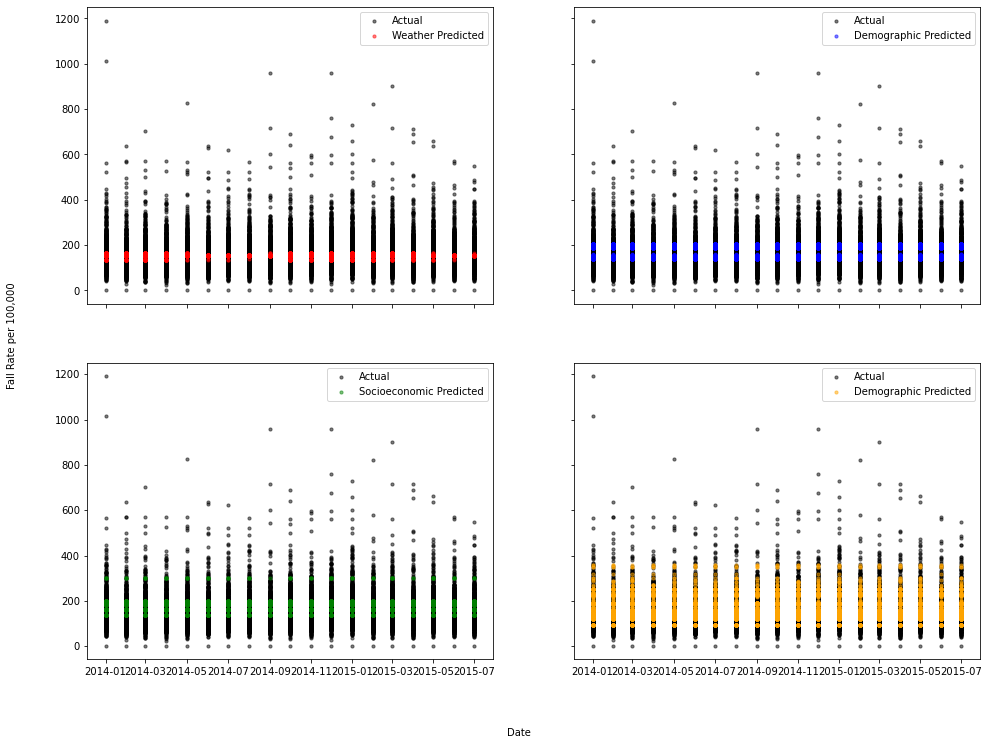

In [1025]:
fig, ax = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(16, 12))


ax[0,0].scatter(test_preds['date'],test_preds['scaled_fall_rate'],color = 'black', alpha = 0.5, s = 10, label = 'Actual')
ax[0,0].scatter(test_preds['date'],test_preds['weather_pred'], color = 'red', alpha = 0.5, s = 10, label = 'Weather Predicted')
ax[0,0].legend(loc="upper right")

ax[0, 1].scatter(test_preds['date'],test_preds['scaled_fall_rate'],color = 'black', alpha = 0.5, s = 10, label = 'Actual')
ax[0, 1].scatter(test_preds['date'],test_preds['demo_pred'], color = 'blue', alpha = 0.5, s = 10, label = 'Demographic Predicted')
ax[0,1].legend(loc="upper right")

ax[1, 0].scatter(test_preds['date'],test_preds['scaled_fall_rate'],color = 'black', alpha = 0.5, s = 10, label = 'Actual')
ax[1, 0].scatter(test_preds['date'],test_preds['econ_pred'], color = 'green', alpha = 0.5, s = 10, label = 'Socioeconomic Predicted')
ax[1,0].legend(loc="upper right")

ax[1, 1].scatter(test_preds['date'],test_preds['scaled_fall_rate'],color = 'black', alpha = 0.5, s = 10, label = 'Actual')
ax[1, 1].scatter(test_preds['date'],test_preds['full_pred'], color = 'orange', alpha = 0.5, s = 10, label = 'Demographic Predicted')
ax[1,1].legend(loc="upper right")


# Set common labels
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'Fall Rate per 100,000', ha='center', va='center', rotation='vertical')

#plt.xlabel('Date')
#plt.ylabel('Fall Rate per 100,000')
#plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
#plt.legend(loc="best")
plt.show()


# Regional Analysis 


Want to create 4 different models for each of the 4 census regions in the US (https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf), split the data into these groups. 



In [1057]:
full_df = pd.read_pickle("full_data.pkl")

In [1058]:
full_df.head()


,month_count,fipscounty,date,tavg_min,tavg_max,tavg_median,tavg_mean,tavg_std,tmin_min,tmin_max,...,tsun_std,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor,pop_density,scaled_fall_rate
0,NaN,1001,2010-01,-3.9,15.6,6.70,5.393103,6.070769,-8.9,11.0,...,NaN,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,NaN
1,14.0,1001,2011-01,-2.3,16.1,6.70,5.823333,4.301217,-8.0,12.0,...,NaN,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,191.230706
2,NaN,1001,2012-01,0.3,18.9,11.75,11.310714,5.214747,-5.9,17.2,...,NaN,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,NaN
3,NaN,1001,2013-01,5.0,20.9,12.40,12.092308,5.250137,-0.6,17.1,...,NaN,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,NaN
4,NaN,1001,2014-01,-7.2,11.6,3.90,3.485185,4.998669,-10.9,7.0,...,NaN,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,NaN


In [1060]:
#remove the unnecessary weather variables 

full_df.drop(["month_count", "wdir_min", "wdir_max", "wdir_median", "wdir_mean", "wdir_std",
            "wpgt_min", "wpgt_max", "wpgt_median", "wpgt_mean", "wpgt_std",
            "pres_min", "pres_max", "pres_median", "pres_mean", "pres_std",
            "tsun_min", "tsun_max", "tsun_median", "tsun_mean", "tsun_std", 
            'tavg_min', 'tavg_max', 'tavg_median',  'tavg_std',
        'tmin_max', 'tmin_median', 'tmin_mean', 'tmin_std',
       'tmax_min',  'tmax_median', 'tmax_mean', 'tmax_std',
       'prcp_min', 'prcp_mean', 'prcp_median',  'prcp_std',
       'snow_min',  'snow_median', 'snow_mean', 'snow_std',
       'wspd_min',  'wspd_median', 'wspd_mean', 'wspd_std'], axis = 1, inplace = True)


In [822]:
full_df.head()

,fipscounty,date,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor,pop_density,scaled_fall_rate
0,1001,2010-01,5.393103,-8.9,21.9,NaN,NaN,18.0,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,NaN
1,1001,2011-01,5.823333,-8.0,23.0,NaN,NaN,16.8,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,191.230706
2,1001,2012-01,11.310714,-5.9,24.6,NaN,NaN,16.9,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,NaN
3,1001,2013-01,12.092308,-0.6,26.4,NaN,NaN,20.7,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,NaN
4,1001,2014-01,3.485185,-10.9,18.9,NaN,NaN,22.1,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,NaN


In [1061]:
#easy way to deal with the precipitation and snow 
full_df['prcp_max'] = full_df['prcp_max'].replace(np.nan, 0)

full_df['snow_max'] = full_df['snow_max'].replace(np.nan, 0)

In [1062]:
full_df.isnull().sum()

month_count         126267
fipscounty               0
date                     0
tavg_mean             6333
tmin_min               134
tmax_max               135
prcp_max                 0
snow_max                 0
wspd_max              4905
median_income            0
gini_index               0
pop_65_up                0
prop_65_85_up            0
prop_female              0
prop_white_nh            0
prop_poor                0
pop_density              0
scaled_fall_rate    126267
dtype: int64

In [375]:
len(full_df['fipscounty'].unique())

3104

In [376]:
#come back to this
#no_missing_data = full_df.dropna()
#no_missing_data.head()
#print(len(no_missing_data['fipscounty'].unique()))

In [843]:
#add states back in, then group by region 
#use states from the Medicare crosswalk (hopefully easiest)
fips_crosswalk_2015 = pd.read_csv("ssa_fips_state_county2015_nostatewide.csv")
fips_crosswalk_2015.head()

,county,state,ssacounty,fipscounty,cbsaold,cbsanameold,cbsa,cbsaname,ssastate,fipsstate
0,AUTAUGA,AL,1000,1001,33860.0,"Montgomery, AL",33860.0,"Montgomery, AL",1,1
1,BALDWIN,AL,1010,1003,NaN,NaN,19300.0,"Daphne-Fairhope-Foley, AL",1,1
2,BARBOUR,AL,1020,1005,NaN,NaN,NaN,NaN,1,1
3,BIBB,AL,1030,1007,13820.0,"Birmingham-Hoover, AL",13820.0,"Birmingham-Hoover, AL",1,1
4,BLOUNT,AL,1040,1009,13820.0,"Birmingham-Hoover, AL",13820.0,"Birmingham-Hoover, AL",1,1


In [827]:
crosswalk_small = fips_crosswalk_2015[['state', 'fipscounty']]

In [1063]:
datawstates = full_df.merge(crosswalk_small, left_on= 'fipscounty', right_on = 'fipscounty', how = 'inner')
datawstates.head()

,month_count,fipscounty,date,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor,pop_density,scaled_fall_rate,state
0,NaN,1001,2010-01,5.393103,-8.9,21.9,0.0,0.0,18.0,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,NaN,AL
1,14.0,1001,2011-01,5.823333,-8.0,23.0,0.0,0.0,16.8,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,191.230706,AL
2,NaN,1001,2012-01,11.310714,-5.9,24.6,0.0,0.0,16.9,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,NaN,AL
3,NaN,1001,2013-01,12.092308,-0.6,26.4,0.0,0.0,20.7,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,NaN,AL
4,NaN,1001,2014-01,3.485185,-10.9,18.9,0.0,0.0,22.1,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,6.439718,NaN,AL


In [829]:
len(datawstates['fipscounty'].unique())

3104

In [840]:
west_region_df.head()

,date,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor,pop_density,scaled_fall_rate,prcp_mean
4667,2010-01-01,-4.548276,-7.2,18.8,49.9,0.0,15.9,16458.0,0.4693,8984,0.109083,0.539849,0.329252,0.230298,1.004329,122.439893,49.9
4670,2013-01-01,-7.596552,-16.0,21.7,12.5,0.0,21.4,16458.0,0.4693,8984,0.109083,0.539849,0.329252,0.230298,1.004329,122.439893,12.5
4671,2014-01-01,-0.396154,-6.9,22.3,0.2,0.0,25.5,16458.0,0.4693,8984,0.109083,0.539849,0.329252,0.230298,1.004329,122.439893,0.2
4674,2011-02-01,-2.518519,-16.1,24.9,5.4,0.0,23.2,16458.0,0.4693,8984,0.109083,0.539849,0.329252,0.230298,1.004329,166.963491,5.4
4676,2013-02-01,-1.614815,-10.0,21.2,5.7,0.0,22.9,16458.0,0.4693,8984,0.109083,0.539849,0.329252,0.230298,1.004329,122.439893,5.7


In [836]:
def region_preparing(region_df):
    '''
    Takes region dataframe and turns it into time dataframe ready for train/test split
    '''
    
    region_df.dropna(inplace=True)
    print(len(region_df['fipscounty'].unique()))
    region_df.drop(['fipscounty','state', 'west_region', 'midwest_region', 'south_region', 'northeast_region' ], axis=1, inplace = True)
    region_df['date'] = pd.to_datetime(region_df['date'])
    region_time_df = region_df.set_index('date')
    
    return region_time_df
    

In [848]:
west_time_df = region_preparing(west_region_df)
west_time_df.describe()

193


/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df.dropna(inplace=True)
/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor,pop_density,scaled_fall_rate,prcp_mean
count,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8.622000e+03,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000
mean,13.151777,0.662085,27.343656,5.648399,5.739968,21.824217,26157.791928,0.446750,9.236943e+04,0.129123,0.546332,0.803098,0.085244,38.160117,112.545778,5.648399
std,8.253066,9.539866,8.899499,11.948152,30.036287,8.230146,5269.690638,0.025947,2.115259e+05,0.018637,0.016344,0.164289,0.027338,116.039832,49.872913,11.948152
min,-17.500000,-36.600000,-13.000000,0.000000,0.000000,0.000000,13558.000000,0.360500,1.699000e+03,0.081226,0.476047,0.197482,0.032697,0.133814,1.217505,0.000000
25%,7.247903,-4.400000,20.600000,0.000000,0.000000,15.800000,22319.000000,0.428400,1.424100e+04,0.117913,0.534107,0.686188,0.067702,3.113644,79.732233,0.000000
50%,13.228309,1.100000,27.800000,0.000000,0.000000,20.900000,25041.000000,0.447600,2.755150e+04,0.128591,0.548133,0.874454,0.077676,7.345651,105.048147,0.000000
75%,19.136667,7.800000,34.400000,6.600000,0.000000,26.600000,29503.000000,0.462700,6.597100e+04,0.141764,0.559122,0.936537,0.097816,28.805077,136.165577,6.600000
max,36.110345,26.700000,49.400000,155.500000,460.000000,58.300000,47489.000000,0.524100,1.149893e+06,0.199125,0.581213,0.981735,0.305495,1181.298402,647.439670,155.500000


In [849]:
midwest_time_df = region_preparing(midwest_region_df)
midwest_time_df.describe()

506


/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df.dropna(inplace=True)
/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor,pop_density,scaled_fall_rate,prcp_mean
count,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000,17203.000000
mean,10.436019,-3.496628,24.851026,10.472208,12.497064,25.011998,26301.288961,0.434089,28653.760681,0.140906,0.564552,0.933132,0.071213,37.494947,161.614751,10.472208
std,10.443752,11.909576,9.455718,17.055039,55.618445,6.948085,4327.369881,0.027825,51521.901013,0.020829,0.013340,0.070312,0.020094,57.749133,60.646786,17.055039
min,-19.066667,-37.800000,-8.000000,0.000000,0.000000,2.400000,12861.000000,0.352500,1008.000000,0.073453,0.498342,0.483938,0.023863,1.002127,31.150568,0.000000
25%,1.353590,-12.800000,17.800000,0.000000,0.000000,20.100000,23194.000000,0.414600,9295.500000,0.127279,0.557667,0.925786,0.056587,11.495886,120.209503,0.000000
50%,11.441935,-2.200000,27.800000,0.900000,0.000000,24.600000,25747.000000,0.432200,15775.000000,0.142579,0.565761,0.954107,0.069830,19.688021,154.229446,0.900000
75%,19.810608,6.700000,32.200000,15.700000,0.000000,29.500000,28342.000000,0.449700,27017.000000,0.155719,0.572306,0.974112,0.081406,35.886116,191.726503,15.700000
max,31.372414,22.000000,45.000000,223.400000,737.000000,70.200000,42133.000000,0.535200,649182.000000,0.238095,0.606787,1.000000,0.175256,407.662860,1190.476190,223.400000


In [850]:
south_time_df = region_preparing(south_region_df)
south_time_df.describe()

838


/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df.dropna(inplace=True)
/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor,pop_density,scaled_fall_rate,prcp_mean
count,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000,30936.000000
mean,16.912792,4.216770,29.576804,14.004474,3.346263,19.453879,24752.689391,0.453495,27563.576577,0.117606,0.563348,0.816525,0.095304,35.911582,170.161716,14.004474
std,8.340665,10.244877,6.305583,35.450225,26.175320,6.574003,5929.715455,0.032183,42010.993466,0.021707,0.019216,0.145999,0.032728,73.917362,75.392864,35.450225
min,-7.289286,-32.800000,2.000000,0.000000,0.000000,0.000000,13148.000000,0.360000,1046.000000,0.049210,0.469969,0.047547,0.027206,1.307995,23.753439,0.000000
25%,9.982759,-3.800000,25.000000,0.000000,0.000000,14.800000,21013.000000,0.432600,8903.000000,0.103233,0.551618,0.755675,0.073839,7.531875,122.783083,0.000000
50%,18.050000,3.300000,30.600000,0.500000,0.000000,19.000000,23453.000000,0.452900,13910.500000,0.116576,0.564516,0.845847,0.088894,14.311177,155.026742,0.500000
75%,24.268966,13.000000,34.400000,22.100000,0.000000,23.700000,26728.000000,0.474500,26248.000000,0.131688,0.575641,0.925449,0.112188,28.186392,197.954470,22.100000
max,34.629032,26.100000,48.000000,4790.400000,864.000000,58.000000,59876.000000,0.561800,379862.000000,0.213159,0.621529,0.995347,0.339693,788.461538,1051.625239,4790.400000


In [851]:
northeast_time_df = region_preparing(northeast_region_df)
northeast_time_df.describe()

196


/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df.dropna(inplace=True)
/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor,pop_density,scaled_fall_rate,prcp_mean
count,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000,10330.000000
mean,10.217088,-2.717386,24.011946,11.699090,14.674056,21.724492,28672.864472,0.442989,50412.670862,0.147074,0.565858,0.903858,0.075032,114.220769,145.447775,11.699090
std,9.558306,10.837183,8.744558,18.928123,69.668059,7.176474,5507.408550,0.028620,55715.041406,0.018548,0.017133,0.119644,0.026712,331.412328,44.272336,18.928123
min,-16.213043,-36.700000,-10.000000,0.000000,0.000000,3.500000,19553.000000,0.366000,3055.000000,0.085763,0.512253,0.239089,0.033884,0.863197,31.949173,0.000000
25%,1.793161,-10.600000,17.000000,0.000000,0.000000,16.500000,24331.750000,0.422900,14347.000000,0.133638,0.555434,0.875616,0.058475,15.336536,116.951865,0.000000
50%,10.967143,-2.000000,26.100000,1.500000,0.000000,21.200000,27360.000000,0.438800,27320.000000,0.148174,0.568167,0.950331,0.071534,30.686288,144.808612,1.500000
75%,18.796774,6.700000,31.600000,18.500000,0.000000,26.400000,31669.000000,0.455600,68417.000000,0.159925,0.578116,0.976307,0.082916,72.361863,171.465614,18.500000
max,31.857143,23.300000,42.200000,203.700000,914.000000,58.300000,45469.000000,0.597500,302335.000000,0.206245,0.617178,0.994908,0.227895,3579.175610,509.482027,203.700000


In [1027]:
#oversample so they're the smme length 
from sklearn.utils import resample

west_resampled = resample(west_time_df, n_samples = 30936, random_state=42)
print(len(west_resampled))
west_resampled.tail()

30936


,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor,pop_density,scaled_fall_rate,prcp_mean
date,,,,,,,,,,,,,,,,
2010-03-01,7.539286,-2.0,21.0,0.0,0.0,17.1,22813.0,0.4136,13816,0.149971,0.529241,0.959902,0.069629,3.073911,94.093804,0.0
2014-12-01,5.162069,-8.0,18.0,0.0,0.0,24.3,33579.0,0.4037,82602,0.132152,0.561064,0.872219,0.069780,25.662192,89.586209,0.0
2015-06-01,23.606897,10.0,38.9,1.3,0.0,27.8,22039.0,0.4244,11360,0.155194,0.551232,0.938468,0.092694,3.277617,96.830986,1.3
2013-10-01,16.248387,5.0,29.4,0.0,0.0,29.5,27161.0,0.4518,173676,0.141528,0.573309,0.664674,0.094014,107.661479,73.124669,0.0
2009-11-01,2.700000,-5.0,12.0,0.0,0.0,21.8,24186.0,0.4320,22376,0.109671,0.534322,0.966839,0.077494,8.025721,75.974258,0.0


30936
Length Training Set:  22482
Training Set Ratio:  0.7267261442979054
Length Testing Set:  8454
Testing Set Ratio:  0.27327385570209467
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}
Train Error is:  -0.8438523328333196
Test Error is: 1.0017
Feature:  tavg_mean Importantance:  0.09189933441877951
Feature:  tmin_min Importantance:  0.5133728040654204
Feature:  tmax_max Importantance:  0.12180661690637724
Feature:  prcp_max Importantance:  0.04373268533039972
Feature:  snow_max Importantance:  0.00330123652951847
Feature:  wspd_max Importantance:  0.22588732274950468


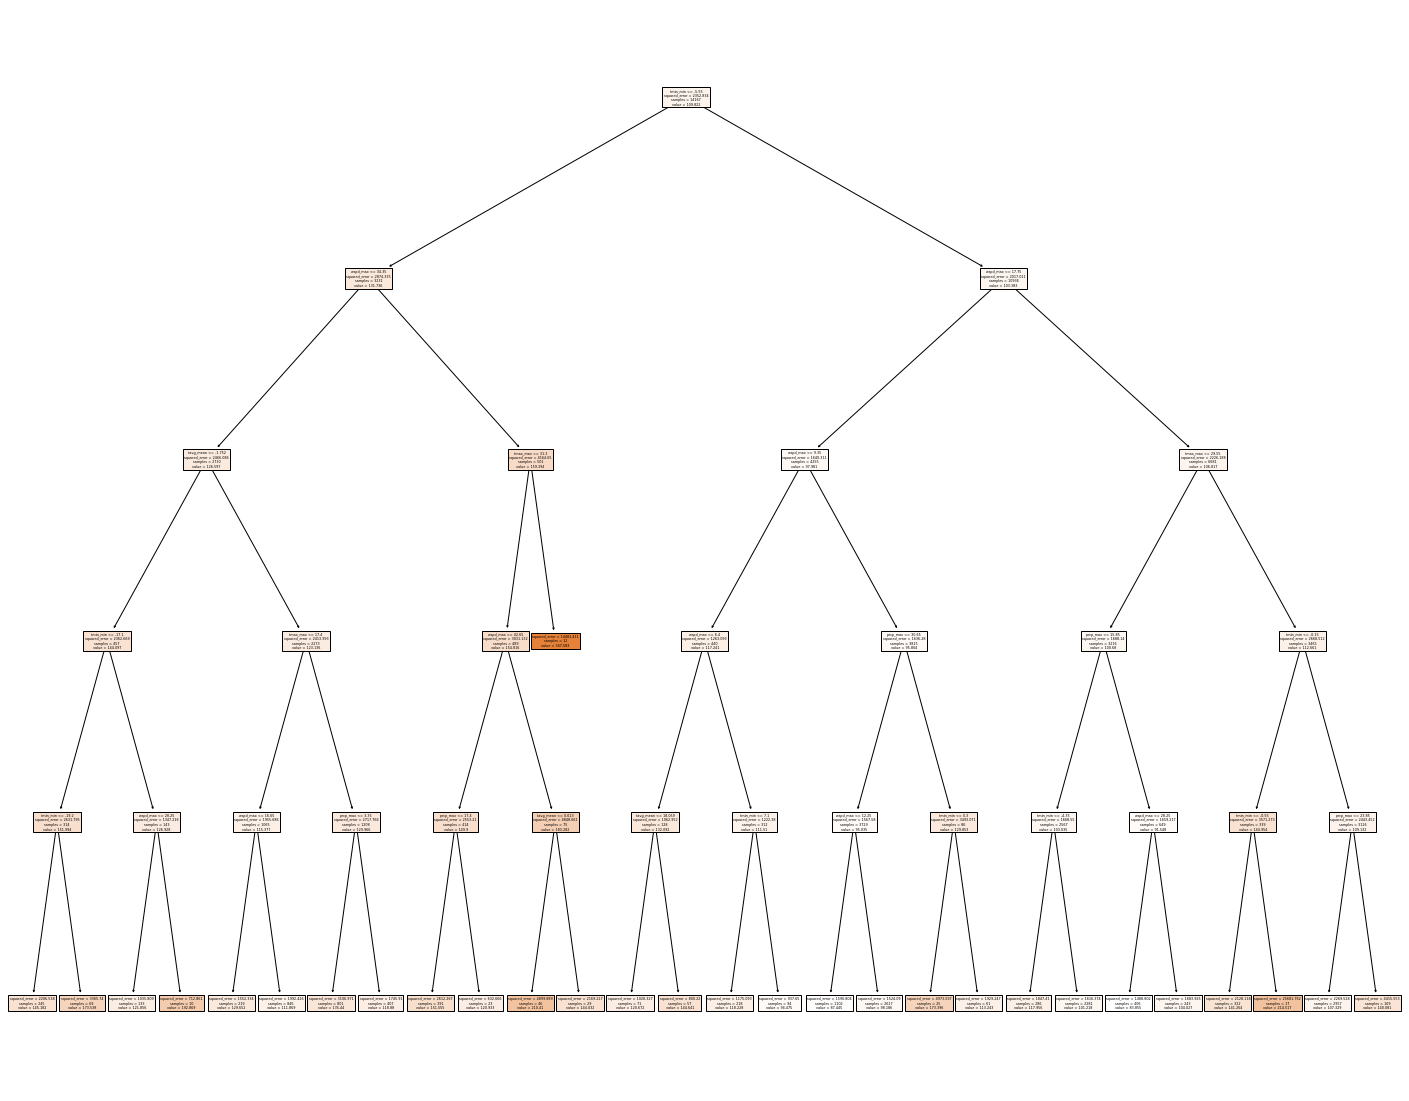

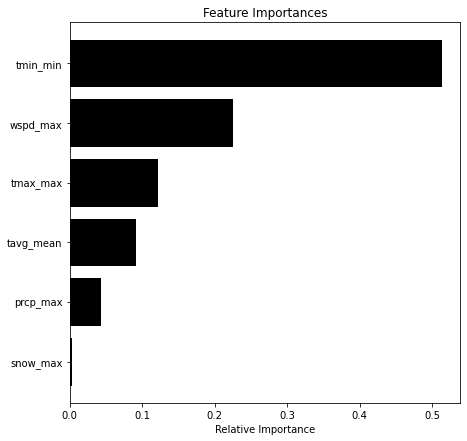

In [1028]:
#West Weather 
west_weather_results = train_test_split(west_resampled, weather_vars, [])
west_weather_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', west_weather_results[0], west_weather_results[1], west_weather_results[2], west_weather_results[3] )

30936
Length Training Set:  22482
Training Set Ratio:  0.7267261442979054
Length Testing Set:  8454
Testing Set Ratio:  0.27327385570209467
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}
Train Error is:  -0.4519517548639135
Test Error is: 0.5320
Feature:  prop_65_85_up Importantance:  0.05725971706868125
Feature:  prop_female Importantance:  0.2618868989166215
Feature:  prop_white_nh Importantance:  0.06801330014484039
Feature:  pop_density Importantance:  0.6128400838698569


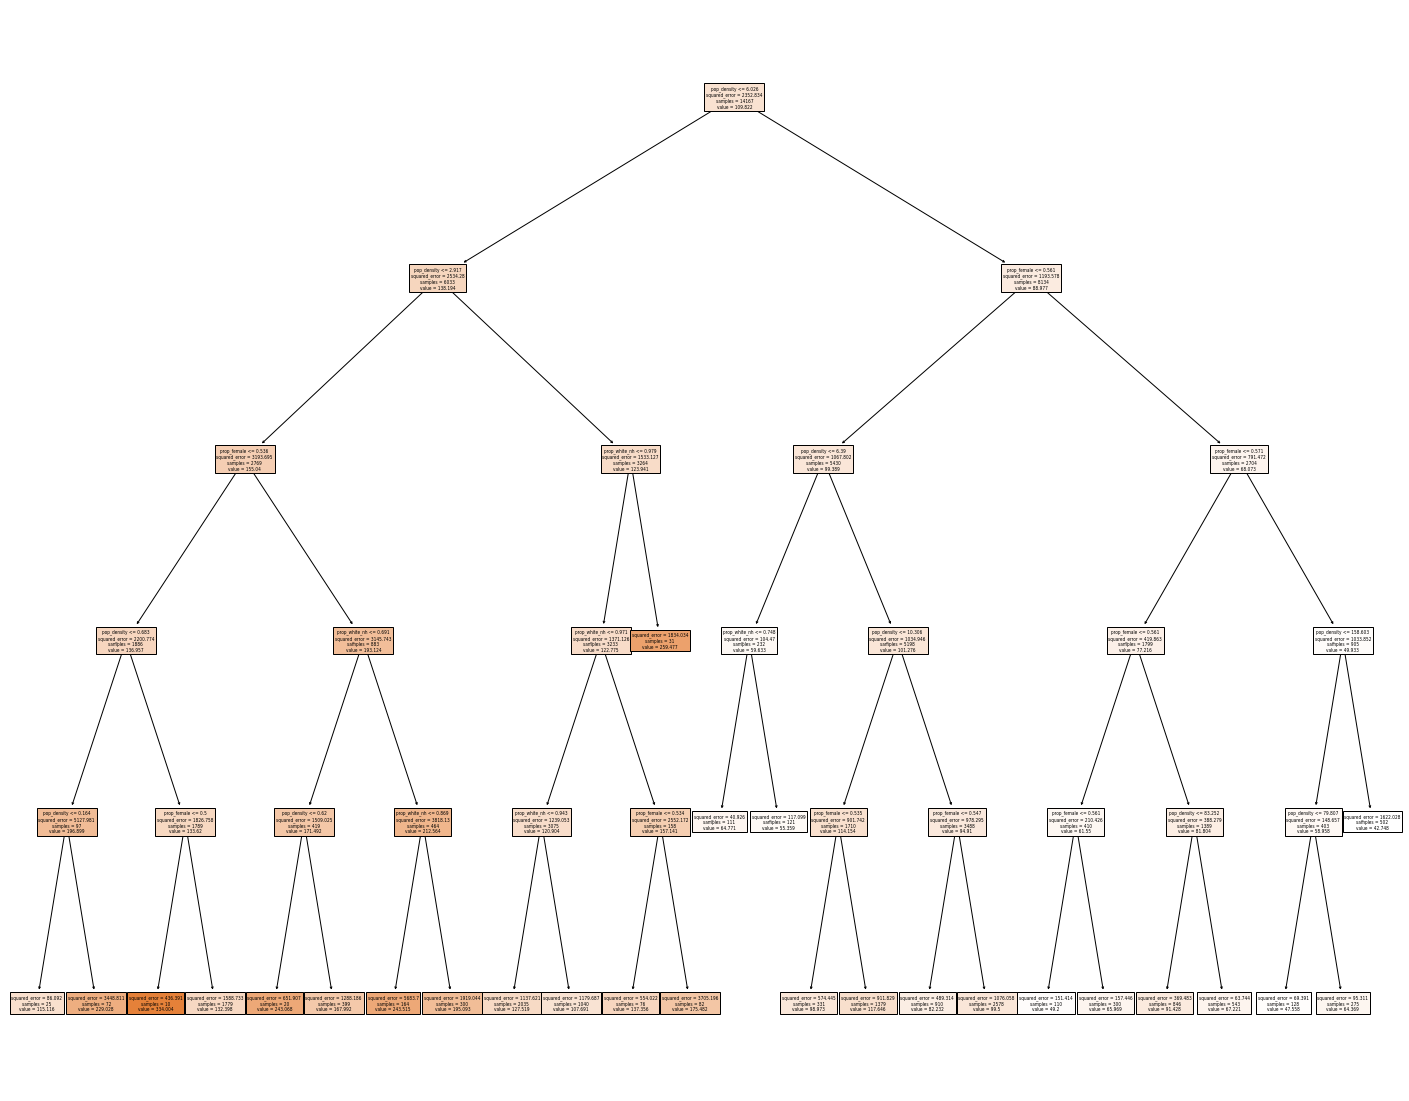

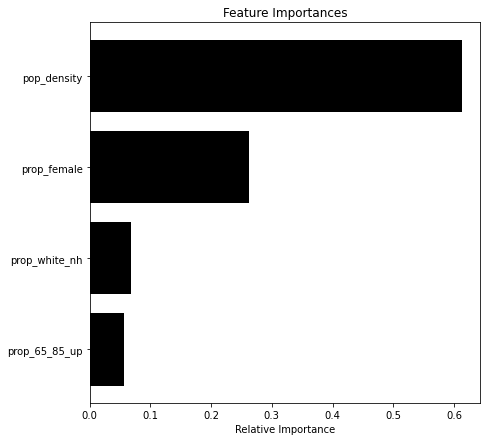

In [1029]:
#West demo 
west_demo_results = train_test_split(west_resampled, demo_vars, [])
west_demo_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', west_demo_results[0], west_demo_results[1], west_demo_results[2], west_demo_results[3] )

30936
Length Training Set:  22482
Training Set Ratio:  0.7267261442979054
Length Testing Set:  8454
Testing Set Ratio:  0.27327385570209467
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}
Train Error is:  -0.4972379621938301
Test Error is: 0.5551
Feature:  median_income Importantance:  0.45386111462043827
Feature:  gini_index Importantance:  0.24978475339795556
Feature:  prop_poor Importantance:  0.2963541319816063


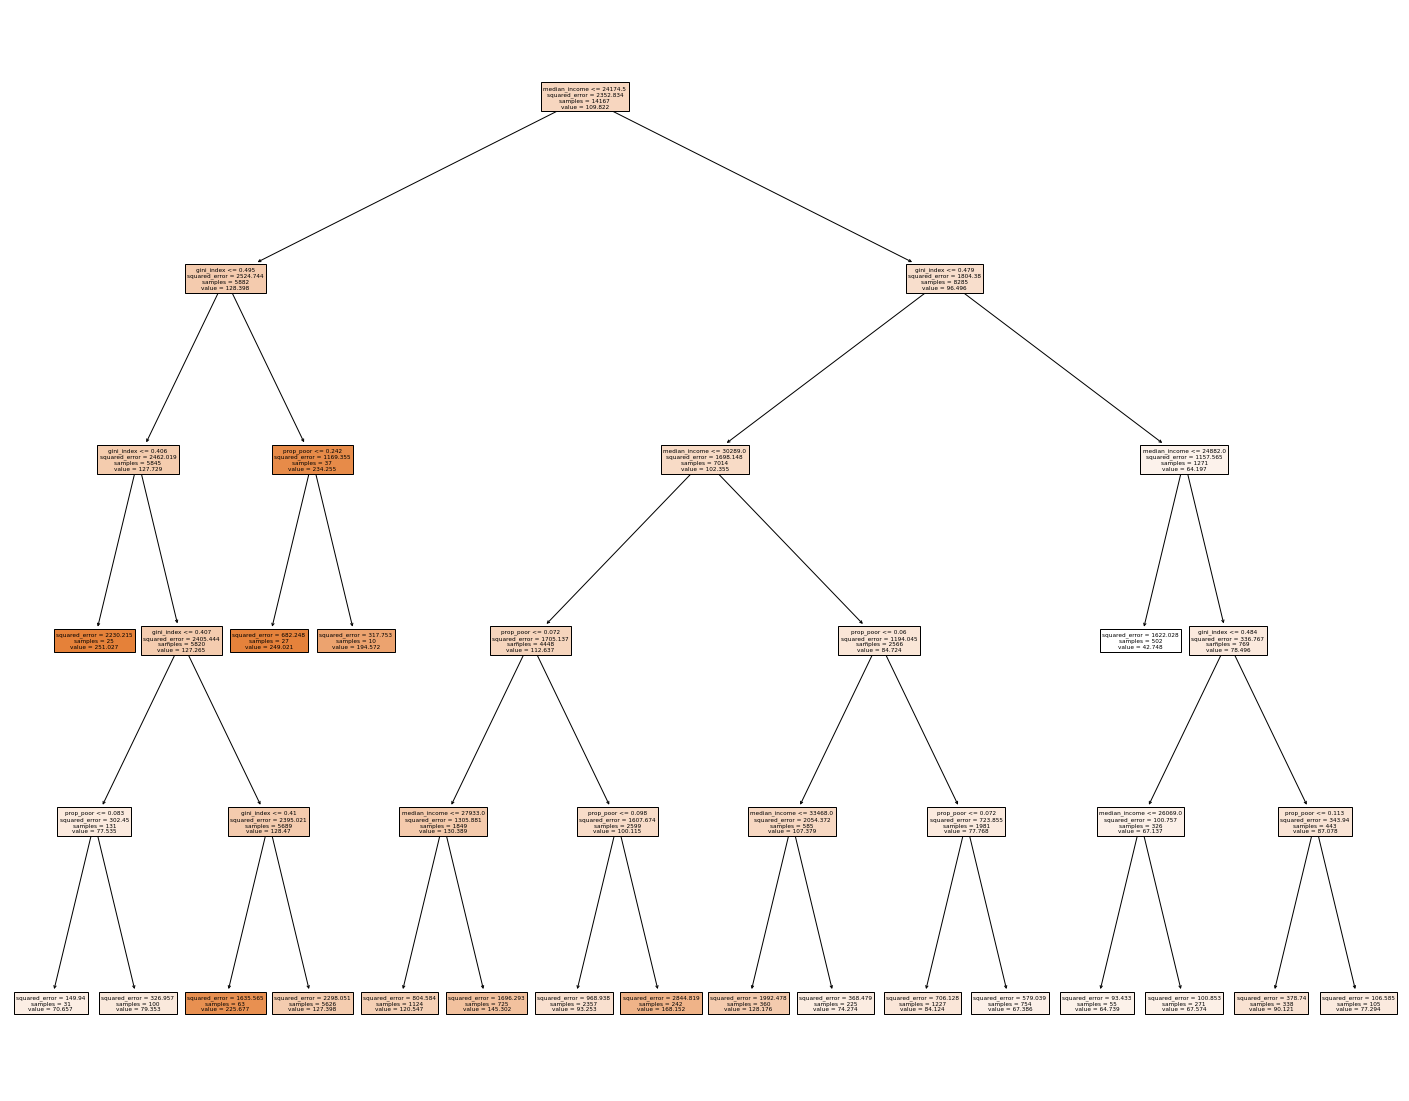

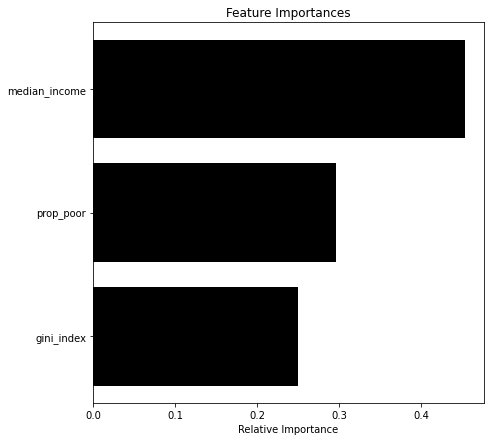

In [1030]:
#West Econ 
west_econ_results = train_test_split(west_resampled, econ_vars, [])
west_econ_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', west_econ_results[0], west_econ_results[1], west_econ_results[2], west_econ_results[3] )

30936
Length Training Set:  22482
Training Set Ratio:  0.7267261442979054
Length Testing Set:  8454
Testing Set Ratio:  0.27327385570209467
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}
Train Error is:  -0.44305023604661886
Test Error is: 0.5325
Feature:  tavg_mean Importantance:  0.0007604060107438624
Feature:  tmin_min Importantance:  0.009557584426837396
Feature:  tmax_max Importantance:  0.0017609508656410598
Feature:  prcp_max Importantance:  0.0034030657299055295
Feature:  snow_max Importantance:  6.3261873659289126e-06
Feature:  wspd_max Importantance:  0.0021130463219823674
Feature:  prop_65_85_up Importantance:  0.019661106418029414
Feature:  prop_female Importantance:  0.22078749448288454
Feature:  prop_white_nh Importantance:  0.03205926682507221
Feature:  pop_density Importantance:  0.5508731414828643
Feature:  median_income Importantance:  0.059188951651436526
Feature:  gini_index Importantance:  0.07970980451663655
Feature:  pro

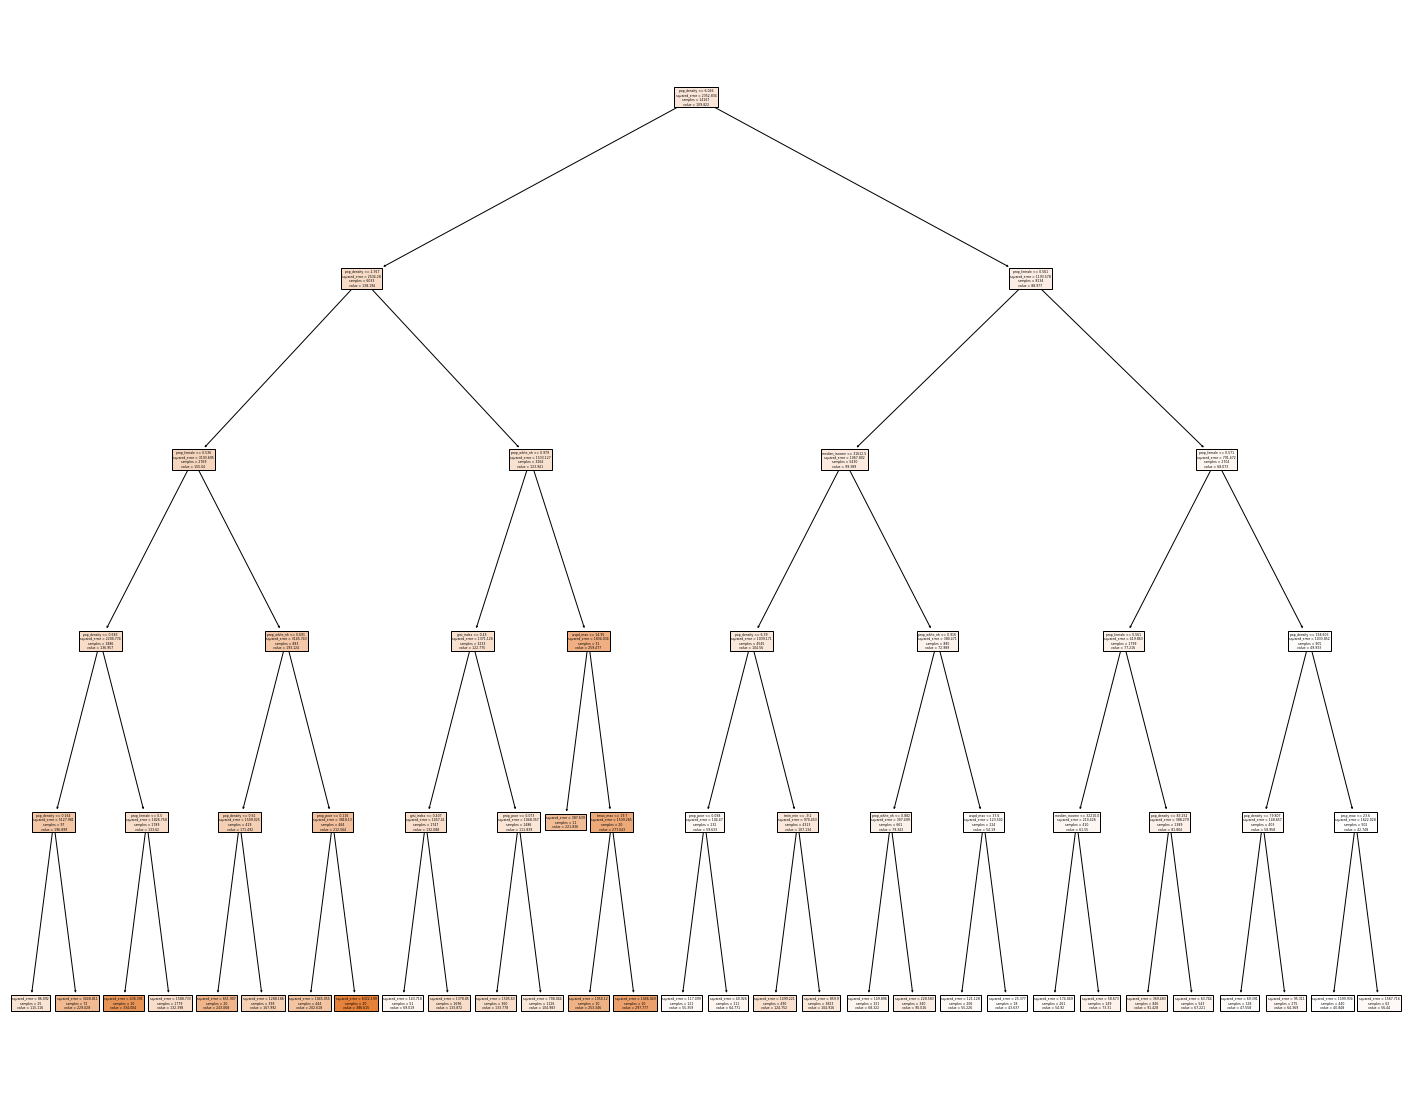

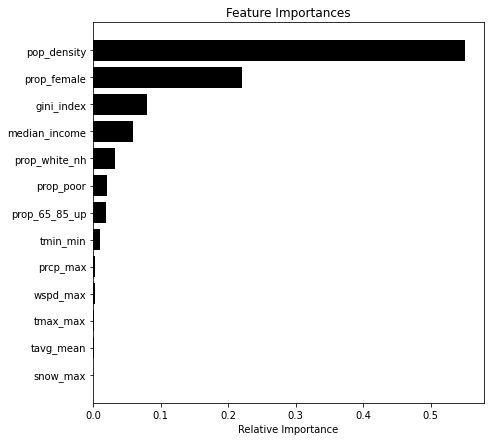

In [1031]:
#West Full 
west_full_results = train_test_split(west_resampled, full_vars, [])
west_full_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', west_full_results[0], west_full_results[1], west_full_results[2], west_full_results[3] )

In [1032]:
#Midwest Sampling
midwest_resampled = resample(midwest_time_df, n_samples = 30936, random_state=42)
print(len(midwest_resampled))

30936


30936
Length Training Set:  22759
Training Set Ratio:  0.7356801137832946
Length Testing Set:  8177
Testing Set Ratio:  0.26431988621670544
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}
Train Error is:  -0.3164149565011552
Test Error is: 0.3193
Feature:  tavg_mean Importantance:  0.0774104870718508
Feature:  tmin_min Importantance:  0.16545761688548752
Feature:  tmax_max Importantance:  0.2823050238755007
Feature:  prcp_max Importantance:  0.1721207352936098
Feature:  snow_max Importantance:  0.019864115209520715
Feature:  wspd_max Importantance:  0.2828420216640304


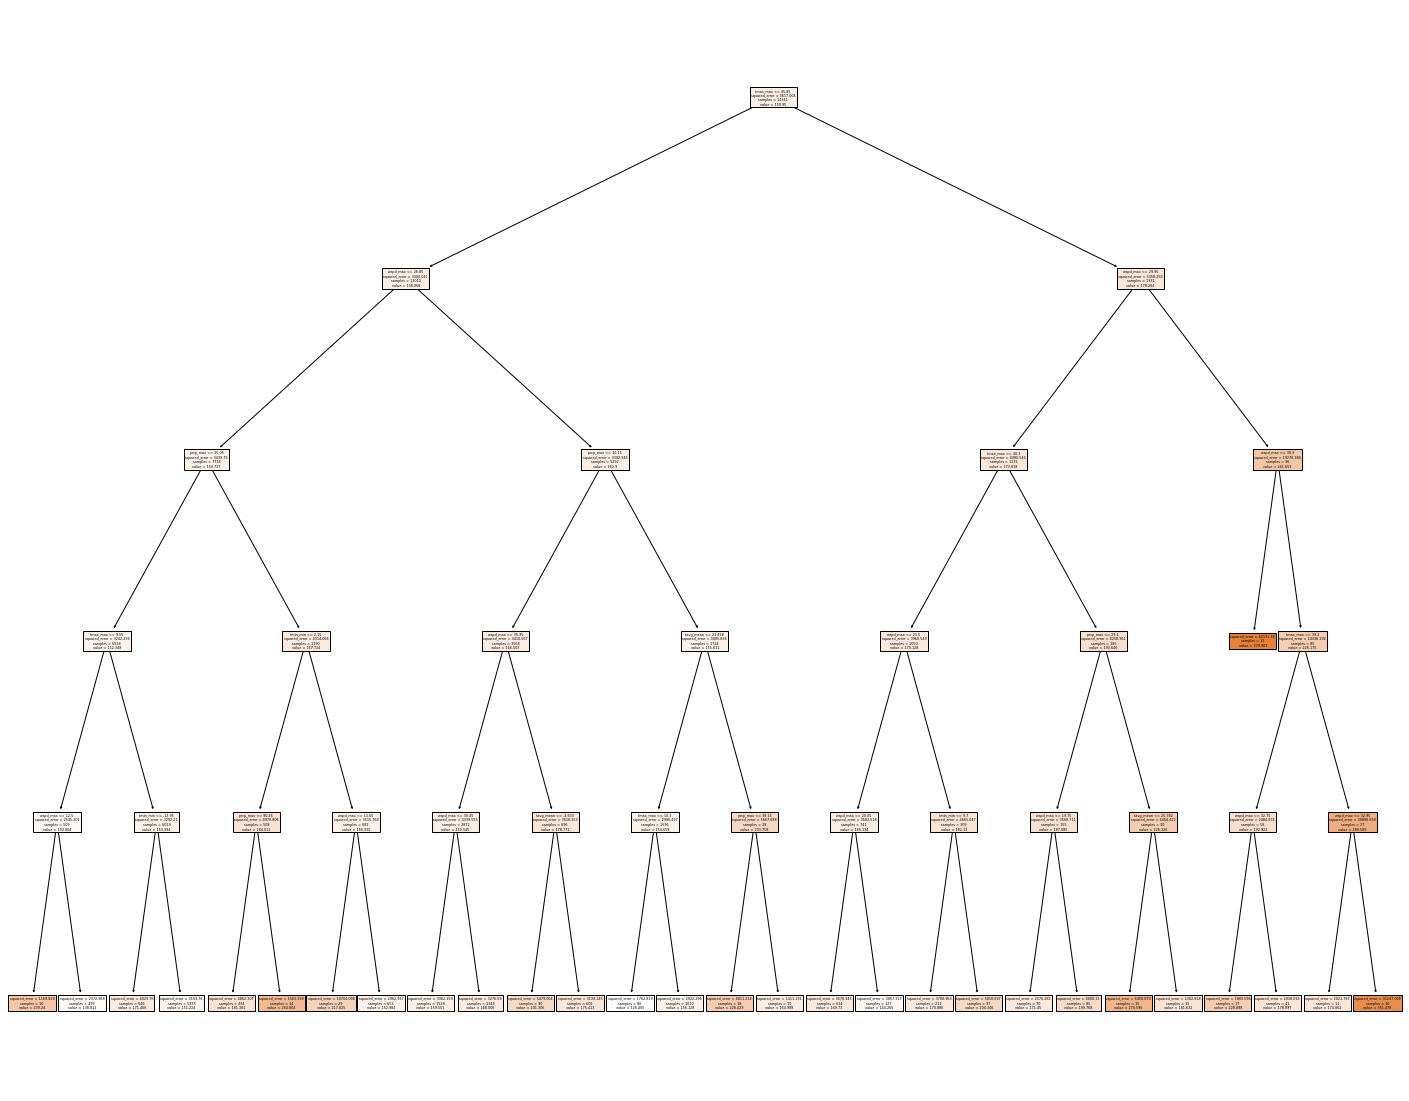

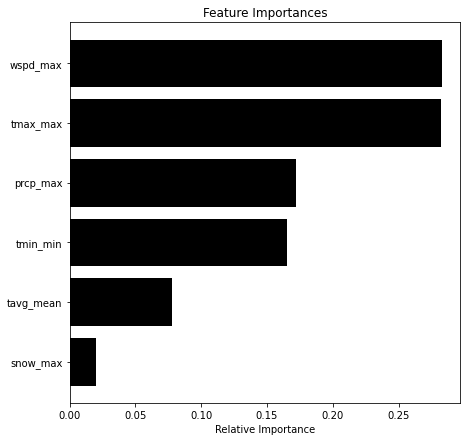

In [1033]:
#Midwest Weather 
midwest_weather_results = train_test_split(midwest_resampled, weather_vars, [])
midwest_weather_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', midwest_weather_results[0], midwest_weather_results[1], midwest_weather_results[2], midwest_weather_results[3] )

30936
Length Training Set:  22759
Training Set Ratio:  0.7356801137832946
Length Testing Set:  8177
Testing Set Ratio:  0.26431988621670544
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Train Error is:  -0.2280846280995684
Test Error is: 0.2470
Feature:  prop_65_85_up Importantance:  0.03174013348952088
Feature:  prop_female Importantance:  0.16108843960181773
Feature:  prop_white_nh Importantance:  0.08899709305705128
Feature:  pop_density Importantance:  0.7181743338516102


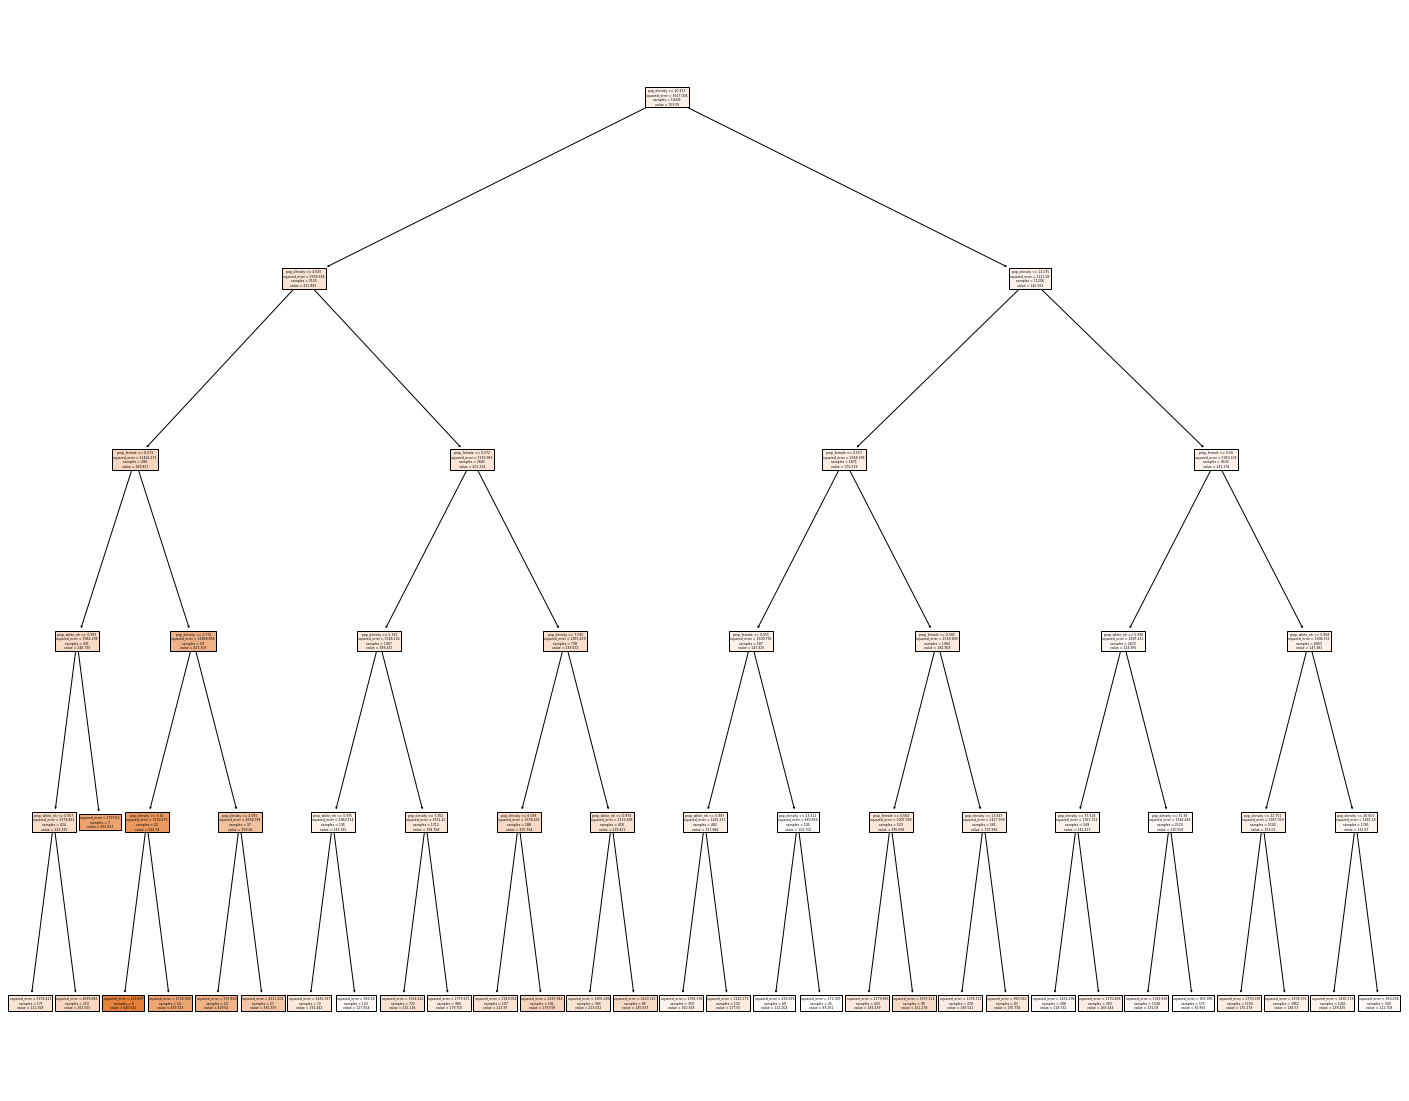

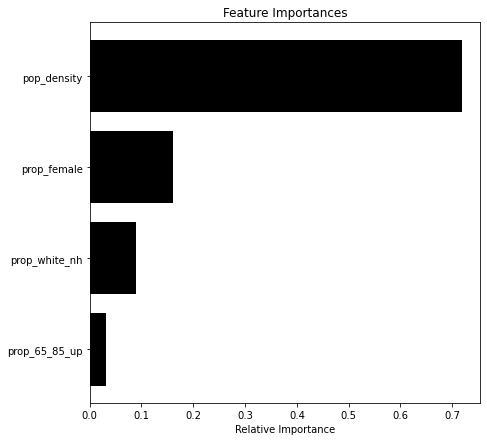

In [1034]:
#Midwest demo 
midwest_demo_results = train_test_split(midwest_resampled, demo_vars, [])
midwest_demo_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', midwest_demo_results[0], midwest_demo_results[1], midwest_demo_results[2], midwest_demo_results[3] )

30936
Length Training Set:  22759
Training Set Ratio:  0.7356801137832946
Length Testing Set:  8177
Testing Set Ratio:  0.26431988621670544
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}
Train Error is:  -0.26825718103839663
Test Error is: 0.2810
Feature:  median_income Importantance:  0.5401906677102118
Feature:  gini_index Importantance:  0.290945966528355
Feature:  prop_poor Importantance:  0.1688633657614332


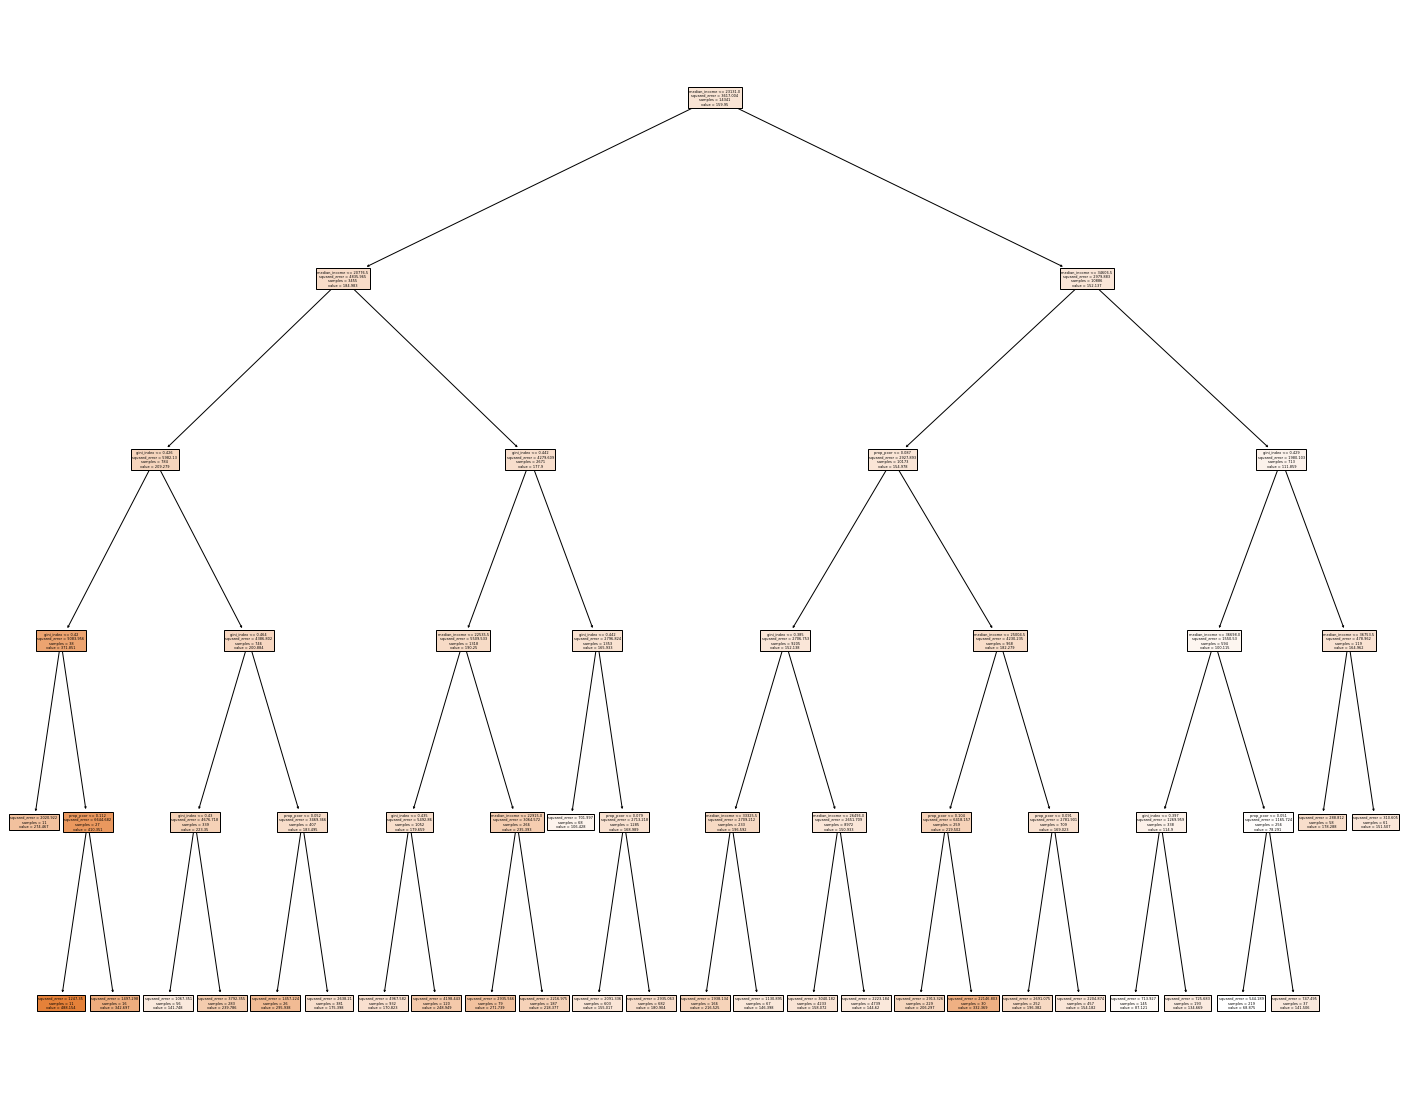

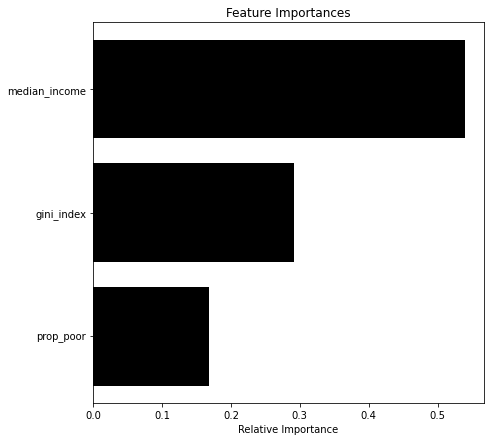

In [1035]:
#midwest Econ 
midwest_econ_results = train_test_split(midwest_resampled, econ_vars, [])
midwest_econ_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', midwest_econ_results[0], midwest_econ_results[1], midwest_econ_results[2], midwest_econ_results[3] )

30936
Length Training Set:  22759
Training Set Ratio:  0.7356801137832946
Length Testing Set:  8177
Testing Set Ratio:  0.26431988621670544
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 50}
Train Error is:  -0.22582983050432434
Test Error is: 0.2454
Feature:  tavg_mean Importantance:  0.00032131991729208965
Feature:  tmin_min Importantance:  0.00012718951604148026
Feature:  tmax_max Importantance:  0.0012337276351979348
Feature:  prcp_max Importantance:  0.001649008600694247
Feature:  snow_max Importantance:  2.8147340220907318e-05
Feature:  wspd_max Importantance:  0.002236602194563084
Feature:  prop_65_85_up Importantance:  0.025052557170254626
Feature:  prop_female Importantance:  0.13832537566649272
Feature:  prop_white_nh Importantance:  0.05074126455165154
Feature:  pop_density Importantance:  0.6883832199276955
Feature:  median_income Importantance:  0.04104514073712887
Feature:  gini_index Importantance:  0.03318514820470425
Feature:  prop

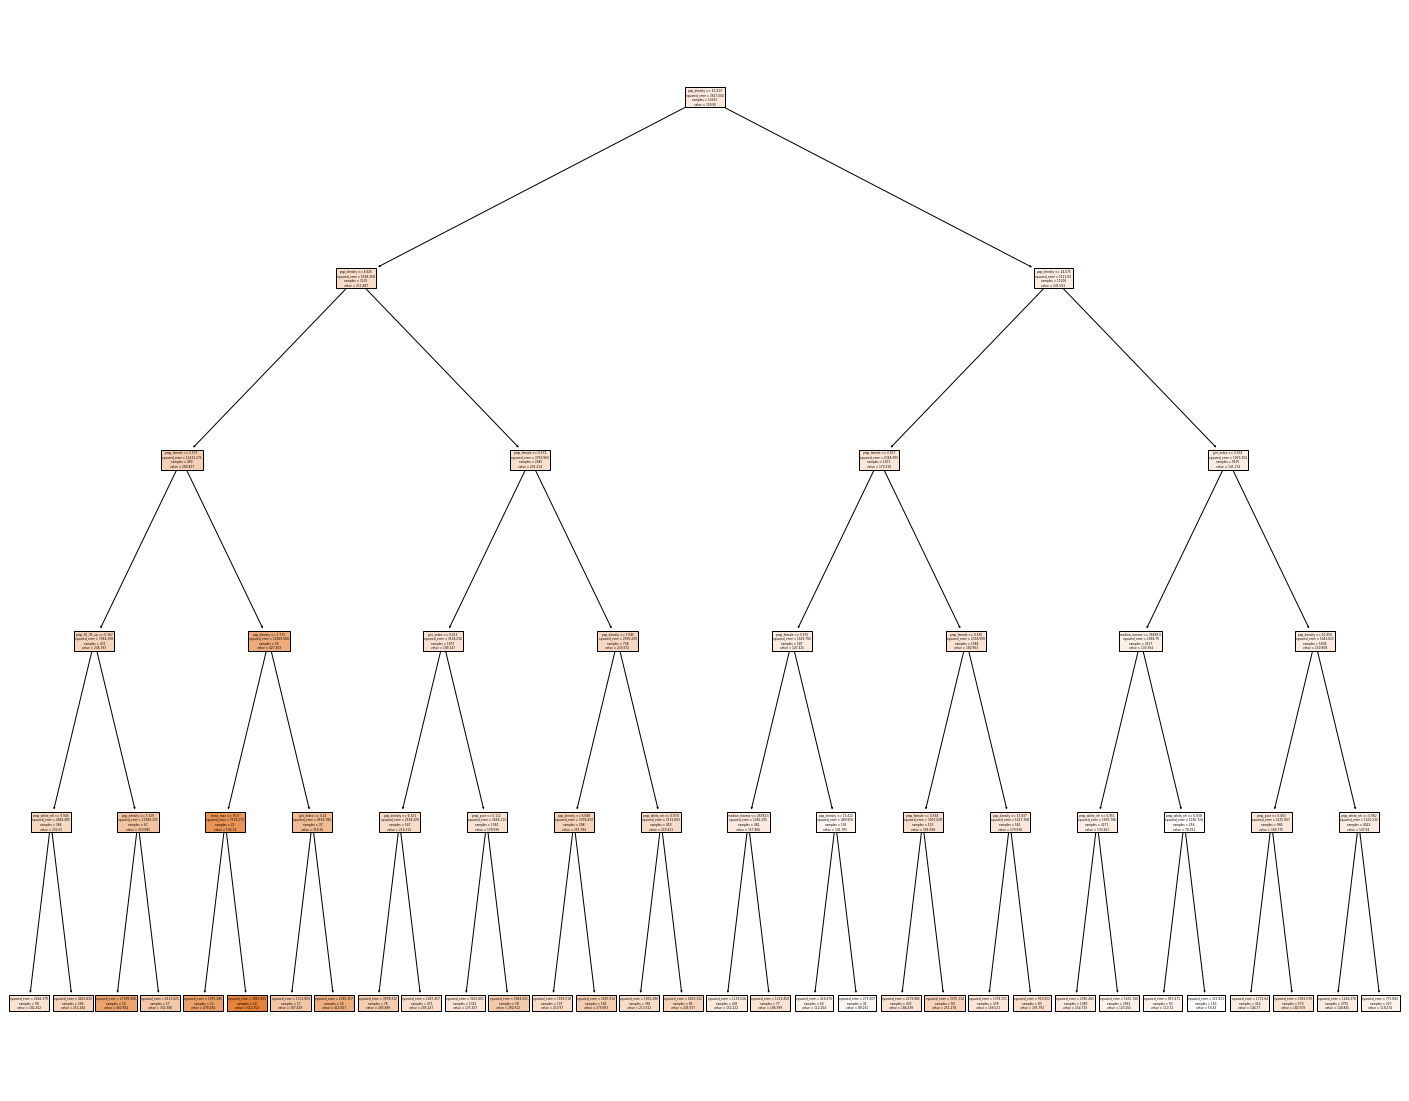

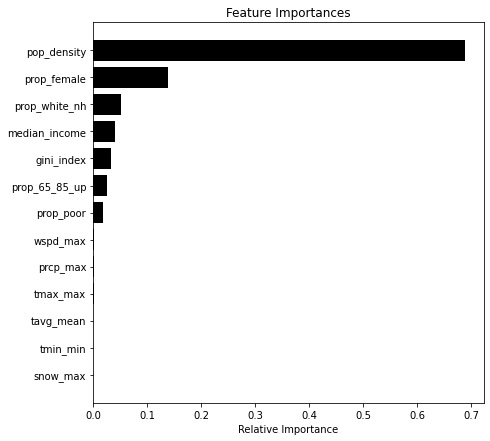

In [1036]:
#midwest Full 
midwest_full_results = train_test_split(midwest_resampled, full_vars, [])
midwest_full_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', midwest_full_results[0], midwest_full_results[1], midwest_full_results[2], midwest_full_results[3] )

30936
Length Training Set:  22545
Training Set Ratio:  0.7287626066718387
Length Testing Set:  8391
Testing Set Ratio:  0.2712373933281614
Best Parameters for Model:  {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 50}
Train Error is:  -0.3479803048424874
Test Error is: 0.3172
Feature:  tavg_mean Importantance:  0.4569370863676942
Feature:  tmin_min Importantance:  0.44315424986355706
Feature:  tmax_max Importantance:  0.03768938297307615
Feature:  prcp_max Importantance:  0.047401081500149246
Feature:  snow_max Importantance:  0.0
Feature:  wspd_max Importantance:  0.014818199295523448


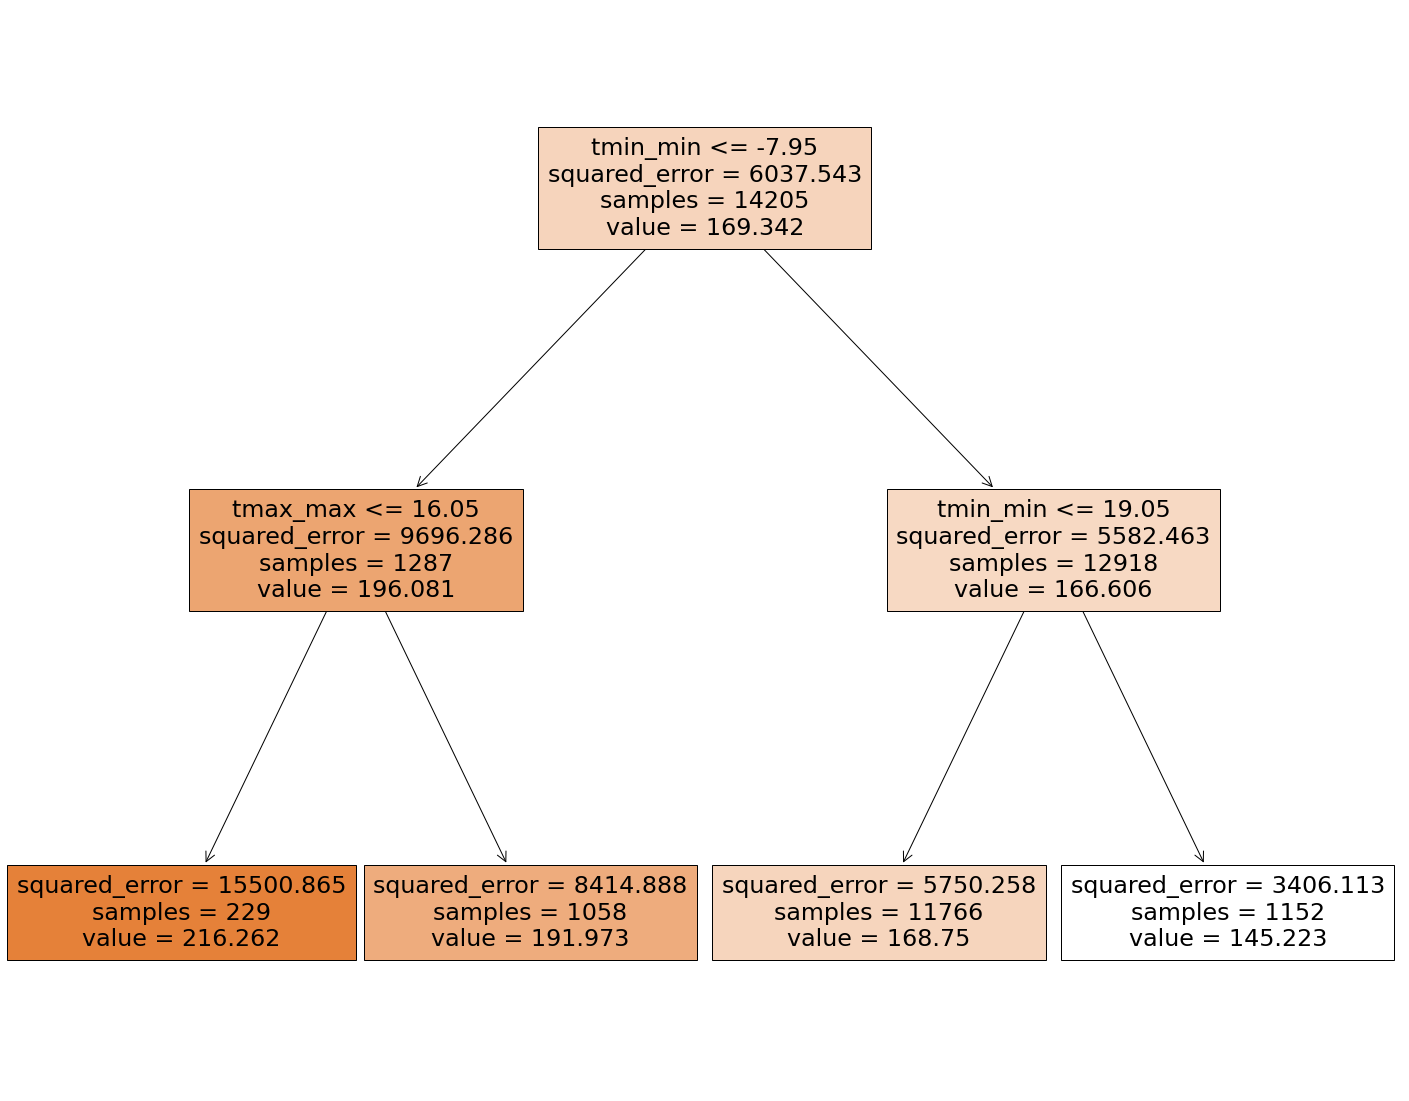

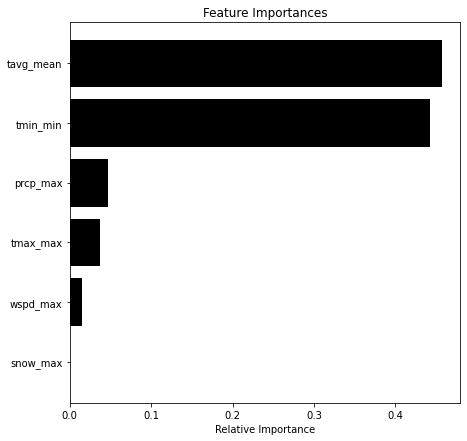

In [1037]:
#South - doesn't need sampling

#South Weather 
south_weather_results = train_test_split(south_time_df, weather_vars, [])
south_weather_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', south_weather_results[0], south_weather_results[1], south_weather_results[2], south_weather_results[3] )

30936
Length Training Set:  22545
Training Set Ratio:  0.7287626066718387
Length Testing Set:  8391
Testing Set Ratio:  0.2712373933281614
Best Parameters for Model:  {'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 200}
Train Error is:  -0.30232806183270733
Test Error is: 0.2616
Feature:  prop_65_85_up Importantance:  0.15350799531361523
Feature:  prop_female Importantance:  0.07809462347868094
Feature:  prop_white_nh Importantance:  0.22386393881576447
Feature:  pop_density Importantance:  0.5445334423919393


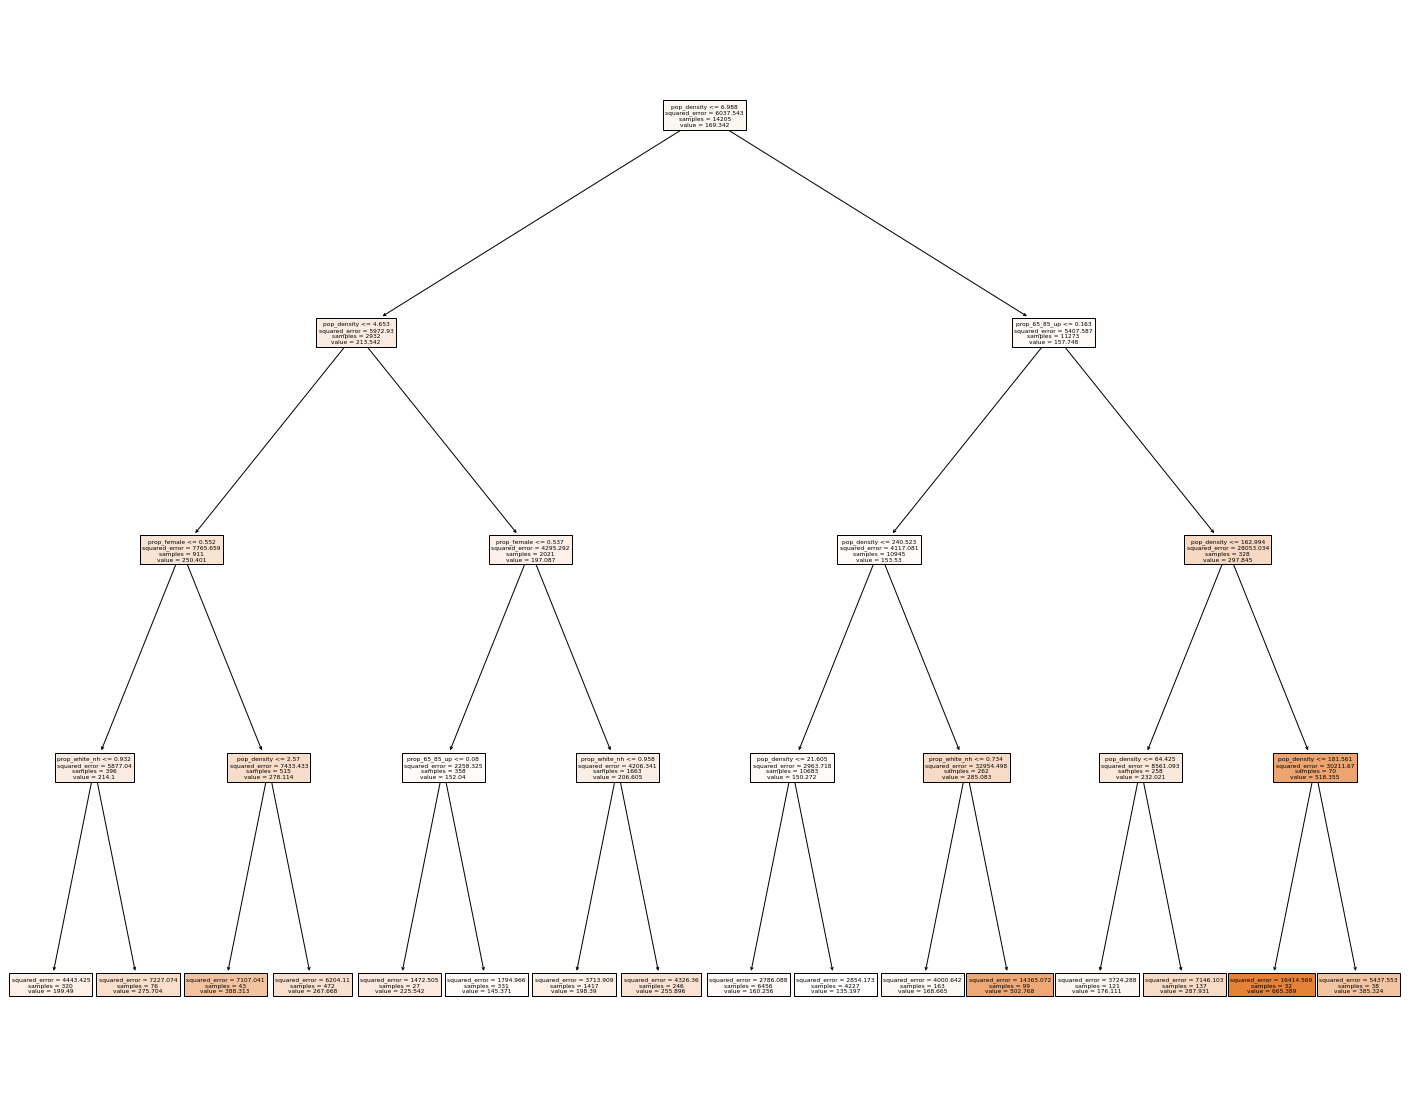

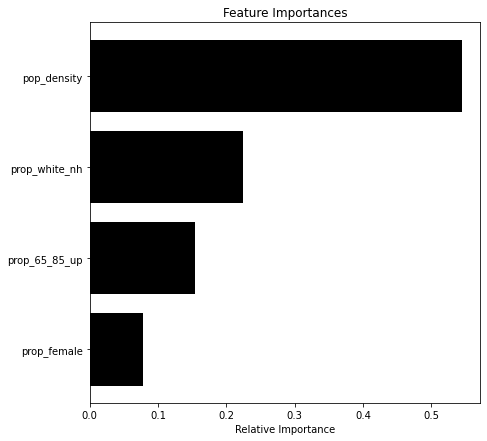

In [1038]:
#South demo 
south_demo_results = train_test_split(south_time_df, demo_vars, [])
south_demo_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', south_demo_results[0], south_demo_results[1], south_demo_results[2], south_demo_results[3] )

30936
Length Training Set:  22545
Training Set Ratio:  0.7287626066718387
Length Testing Set:  8391
Testing Set Ratio:  0.2712373933281614
Best Parameters for Model:  {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 200}
Train Error is:  -0.31402158070315916
Test Error is: 0.2969
Feature:  median_income Importantance:  1.0
Feature:  gini_index Importantance:  0.0
Feature:  prop_poor Importantance:  0.0


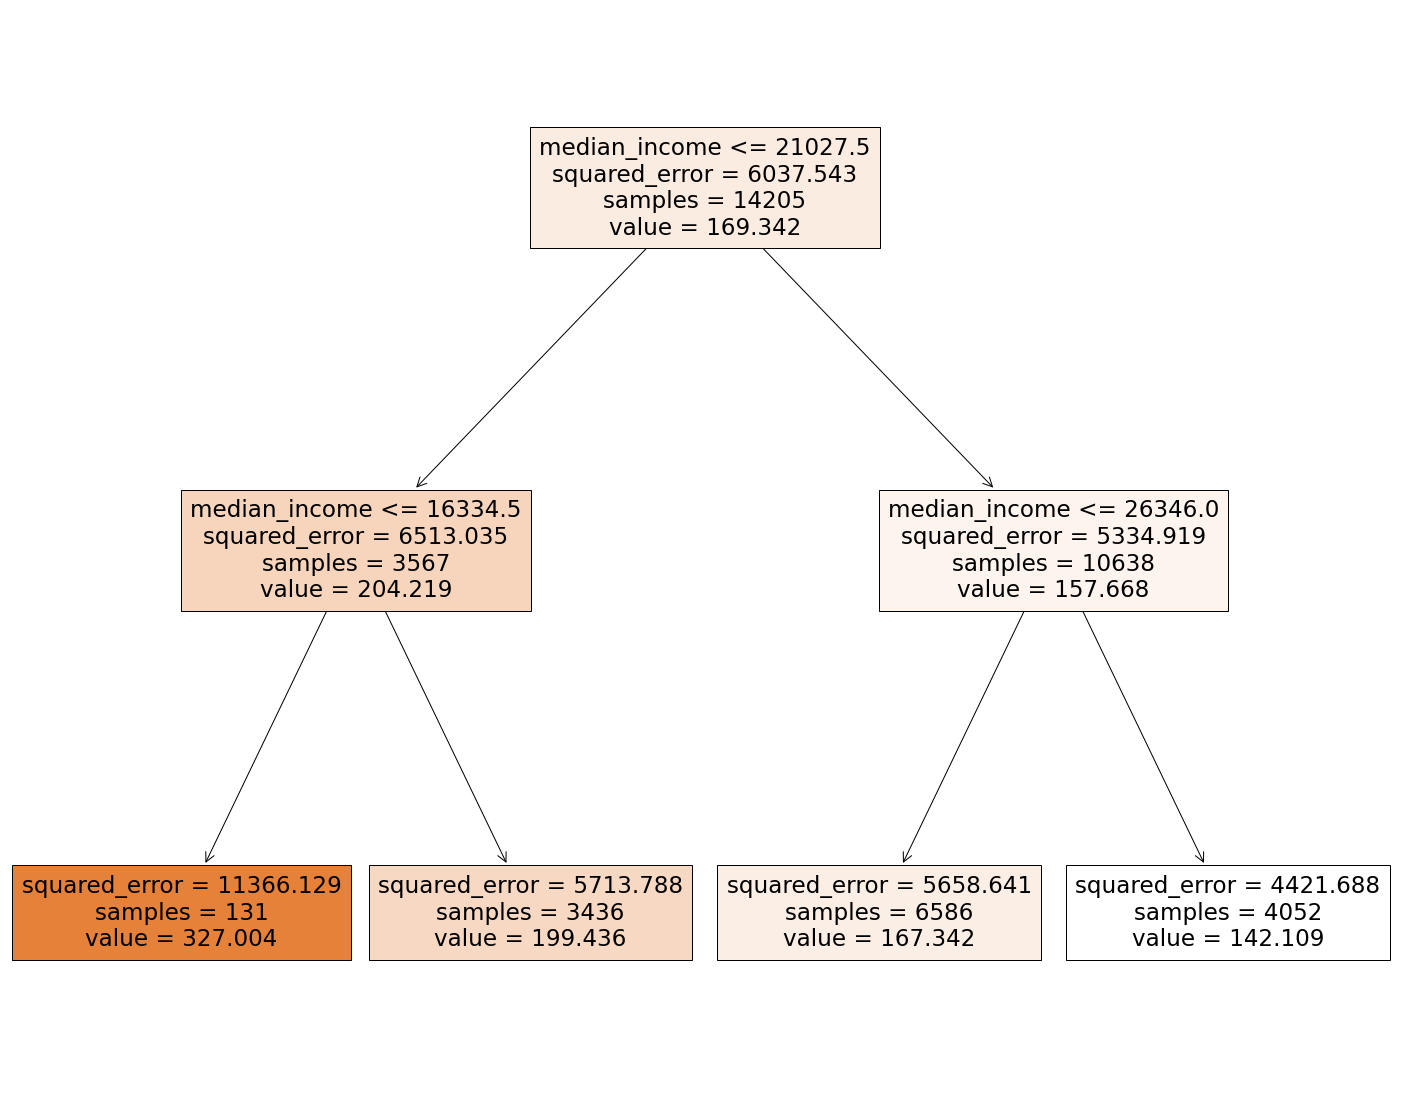

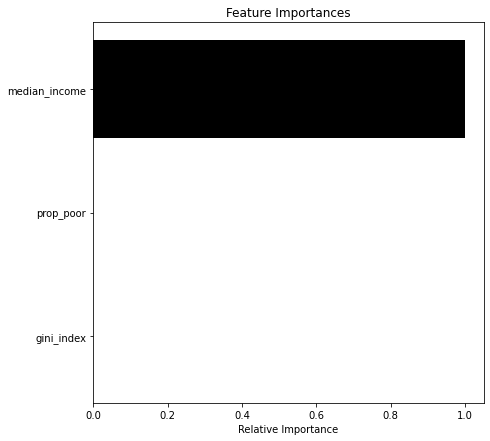

In [1039]:
#South Econ 
south_econ_results = train_test_split(south_time_df, econ_vars, [])
south_econ_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', south_econ_results[0], south_econ_results[1], south_econ_results[2], south_econ_results[3] )

30936
Length Training Set:  22545
Training Set Ratio:  0.7287626066718387
Length Testing Set:  8391
Testing Set Ratio:  0.2712373933281614
Best Parameters for Model:  {'max_depth': 4, 'min_samples_leaf': 10, 'n_estimators': 200}
Train Error is:  -0.2979581843072999
Test Error is: 0.2628
Feature:  tavg_mean Importantance:  0.0
Feature:  tmin_min Importantance:  1.4595766957206362e-06
Feature:  tmax_max Importantance:  0.0
Feature:  prcp_max Importantance:  3.351438031196217e-05
Feature:  snow_max Importantance:  0.0
Feature:  wspd_max Importantance:  8.971782869817446e-05
Feature:  prop_65_85_up Importantance:  0.14016100725412675
Feature:  prop_female Importantance:  0.021277694584691708
Feature:  prop_white_nh Importantance:  0.18789849239887002
Feature:  pop_density Importantance:  0.46486307785175945
Feature:  median_income Importantance:  0.10072725749248913
Feature:  gini_index Importantance:  0.029597514933831656
Feature:  prop_poor Importantance:  0.05535026369852547


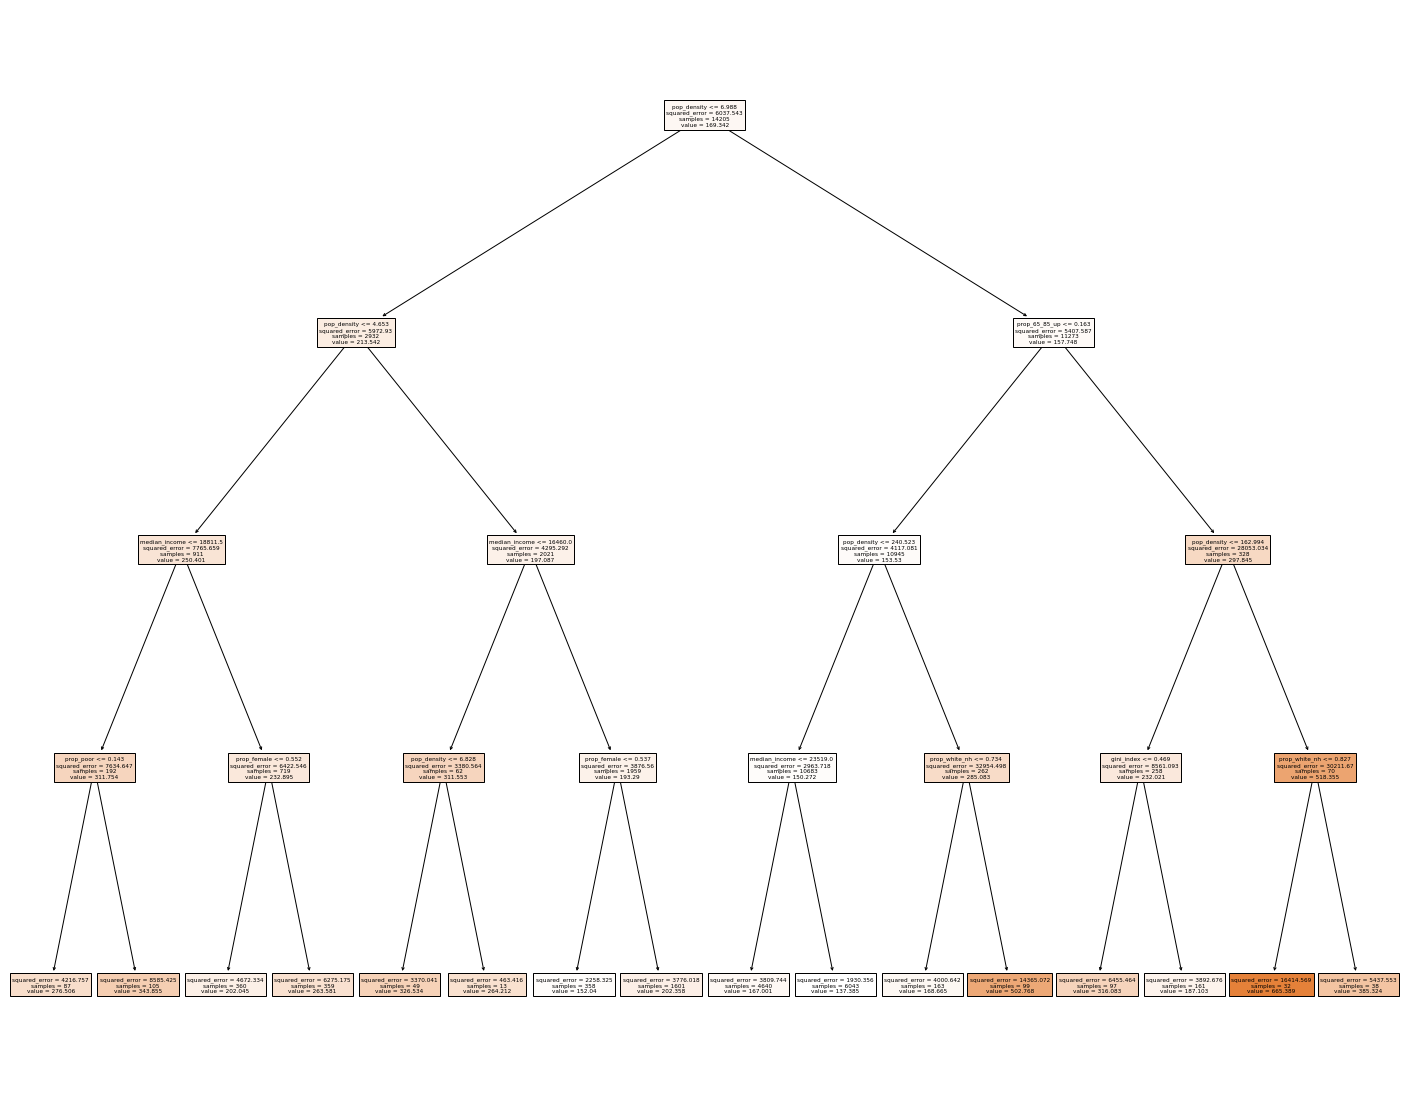

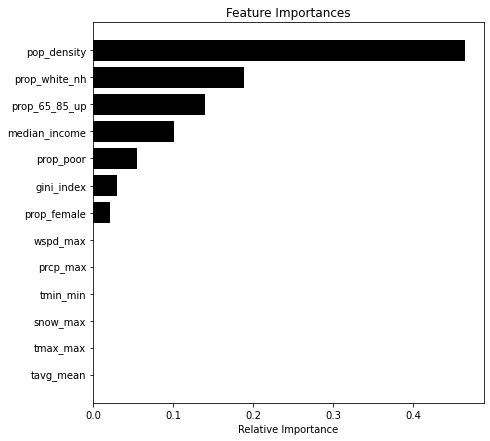

In [1040]:
#South Full 
south_full_results = train_test_split(south_time_df, full_vars, [])
south_full_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', south_full_results[0], south_full_results[1], south_full_results[2], south_full_results[3] )

In [1041]:
#Northeast resampling 
northeast_resampled = resample(northeast_time_df, n_samples = 30936, random_state=42)
print(len(northeast_resampled))

30936


30936
Length Training Set:  22695
Training Set Ratio:  0.733611326609775
Length Testing Set:  8241
Testing Set Ratio:  0.266388673390225
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 200}
Train Error is:  -0.26602819801434646
Test Error is: 0.2955
Feature:  tavg_mean Importantance:  0.08688126578157938
Feature:  tmin_min Importantance:  0.21918578971928723
Feature:  tmax_max Importantance:  0.12460692612017313
Feature:  prcp_max Importantance:  0.15396081197172715
Feature:  snow_max Importantance:  0.10110307110343582
Feature:  wspd_max Importantance:  0.3142621353037972


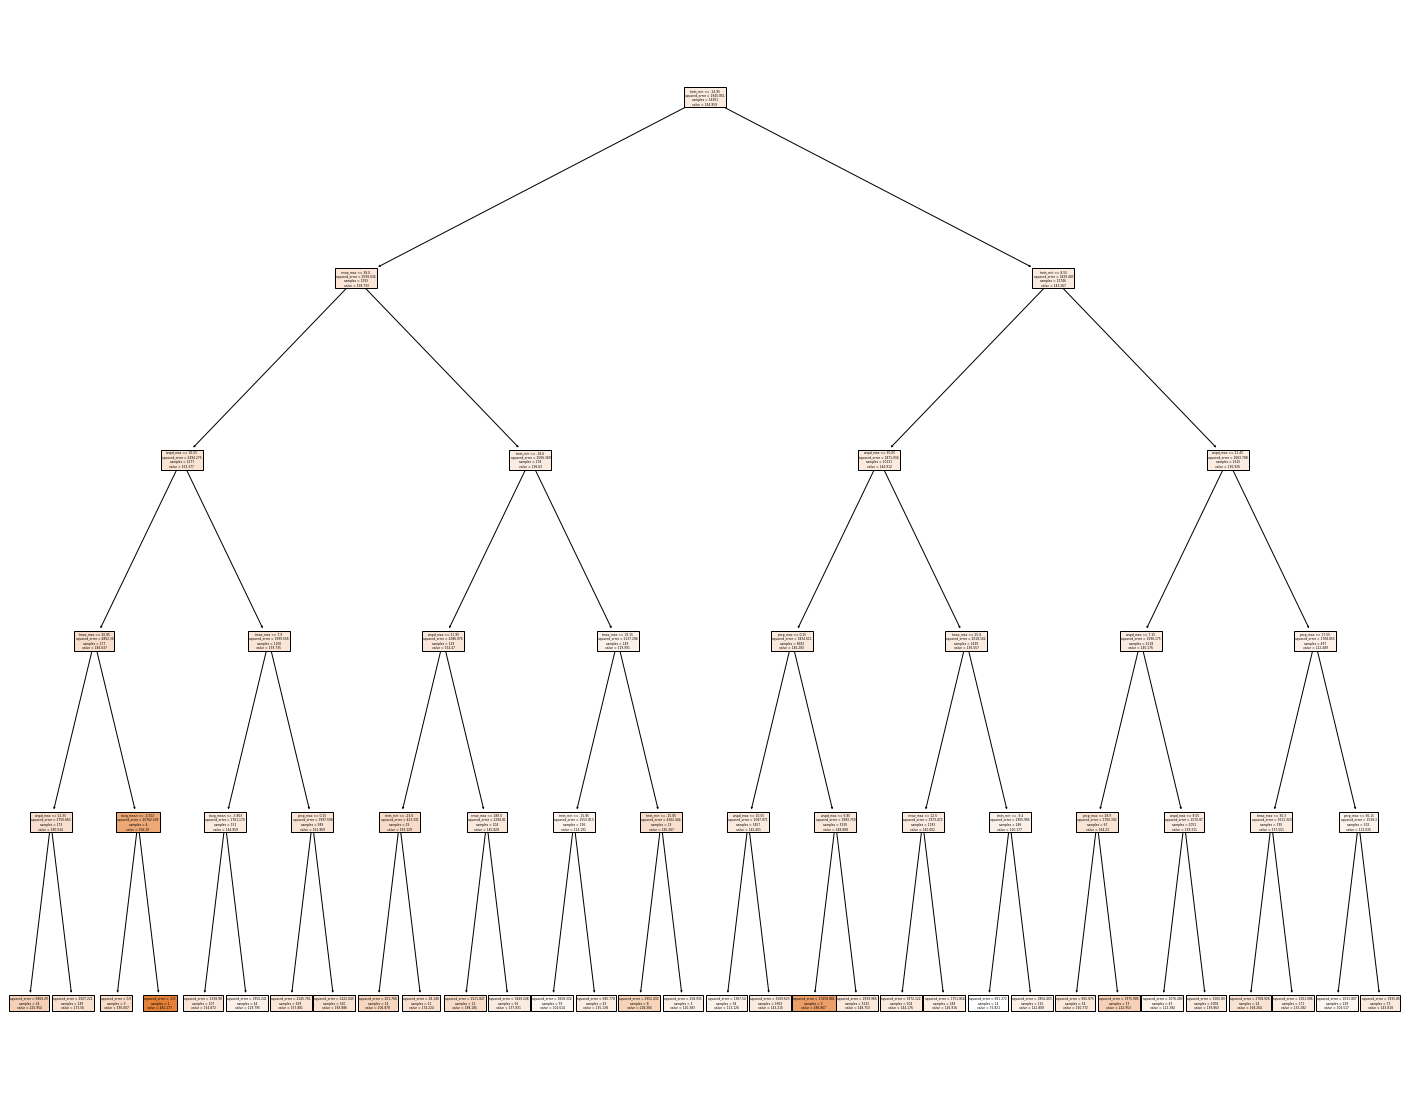

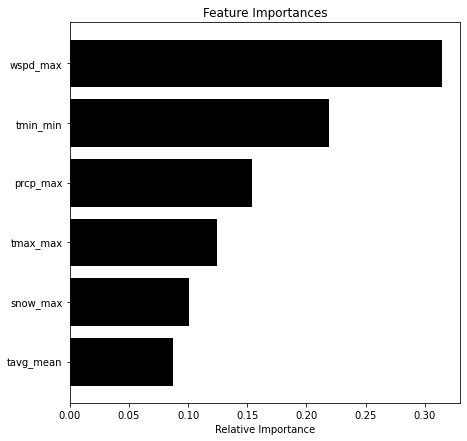

In [1042]:
#Northeast Weather 
northeast_weather_results = train_test_split(northeast_resampled, weather_vars, [])
northeast_weather_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', northeast_weather_results[0], northeast_weather_results[1], northeast_weather_results[2], northeast_weather_results[3] )

30936
Length Training Set:  22695
Training Set Ratio:  0.733611326609775
Length Testing Set:  8241
Testing Set Ratio:  0.266388673390225
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 50}
Train Error is:  -0.2252420024664773
Test Error is: 0.2480
Feature:  prop_65_85_up Importantance:  0.3668939064729225
Feature:  prop_female Importantance:  0.31740955794456077
Feature:  prop_white_nh Importantance:  0.17025008815530873
Feature:  pop_density Importantance:  0.14544644742720808


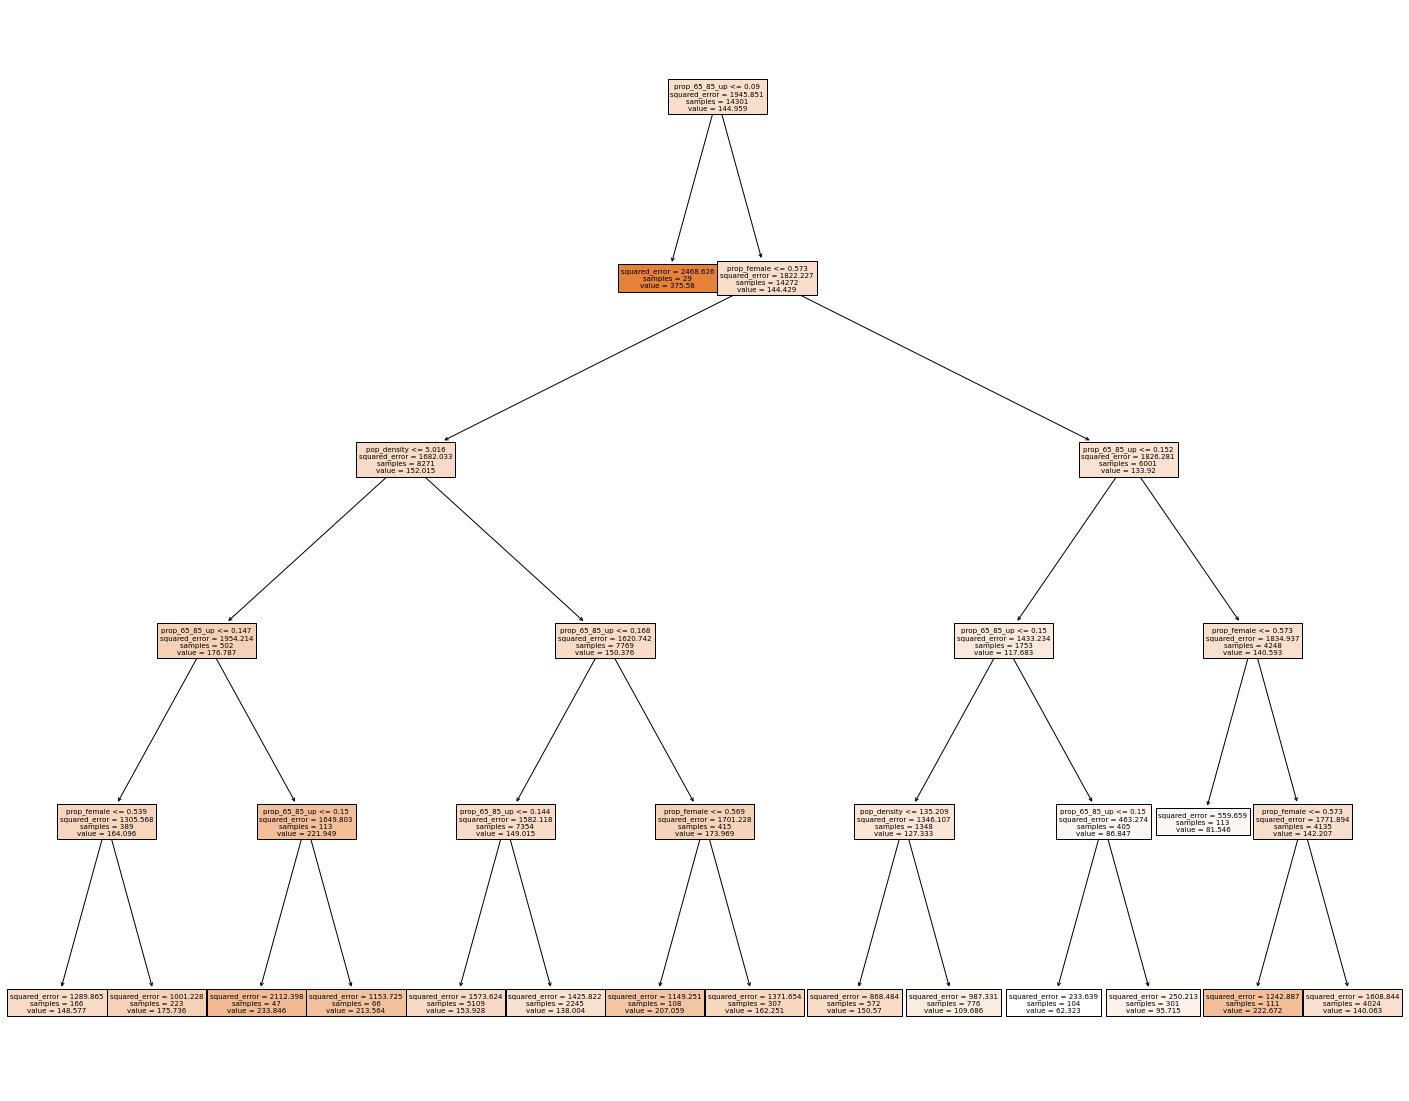

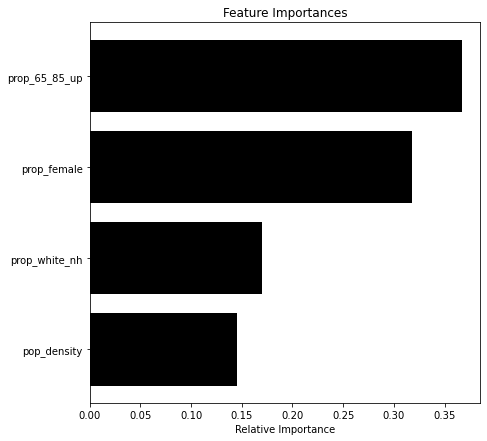

In [1043]:
#Northeast demo 
northeast_demo_results = train_test_split(northeast_resampled, demo_vars, [])
northeast_demo_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', northeast_demo_results[0], northeast_demo_results[1], northeast_demo_results[2], northeast_demo_results[3] )

30936
Length Training Set:  22695
Training Set Ratio:  0.733611326609775
Length Testing Set:  8241
Testing Set Ratio:  0.266388673390225
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 50}
Train Error is:  -0.22460578928173222
Test Error is: 0.2407
Feature:  median_income Importantance:  0.41739397649843557
Feature:  gini_index Importantance:  0.11969725805583606
Feature:  prop_poor Importantance:  0.46290876544572834


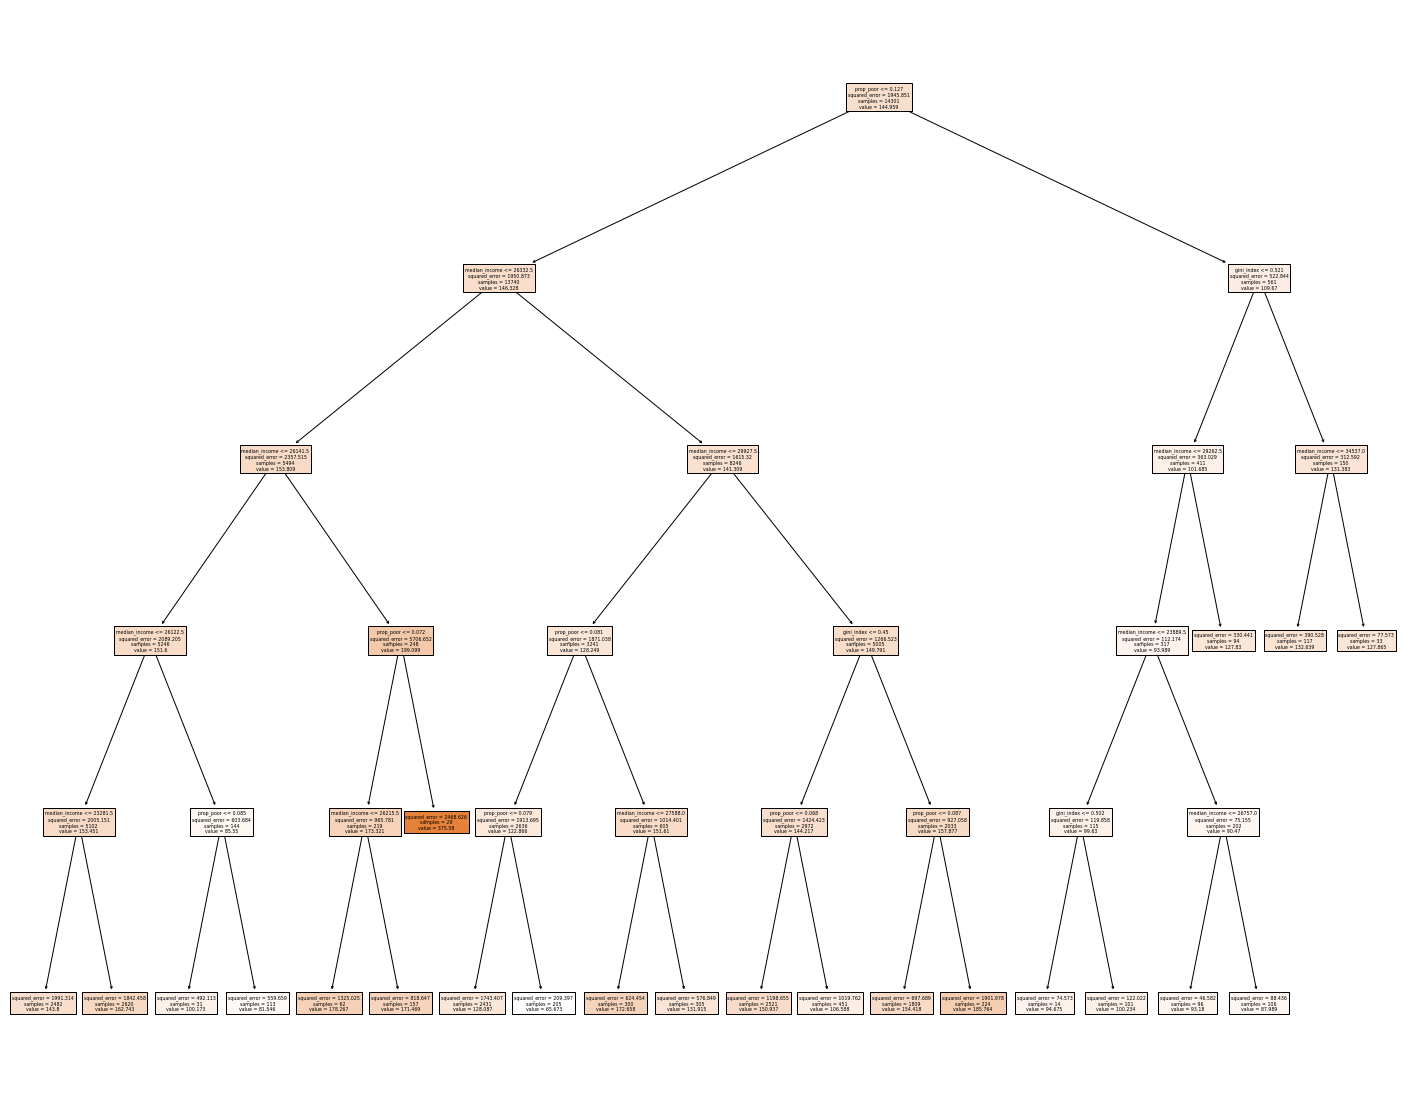

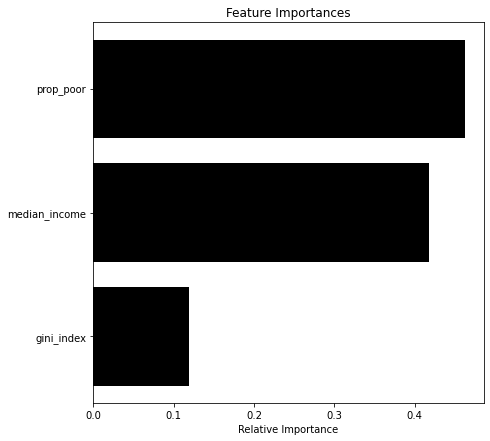

In [1044]:
#Northeast Econ 
northeast_econ_results = train_test_split(northeast_resampled, econ_vars, [])
northeast_econ_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', northeast_econ_results[0], northeast_econ_results[1], northeast_econ_results[2], northeast_econ_results[3] )

30936
Length Training Set:  22695
Training Set Ratio:  0.733611326609775
Length Testing Set:  8241
Testing Set Ratio:  0.266388673390225
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 50}
Train Error is:  -0.21458104518758542
Test Error is: 0.2374
Feature:  tavg_mean Importantance:  0.0017882767558659231
Feature:  tmin_min Importantance:  0.0007968913389224784
Feature:  tmax_max Importantance:  0.004516344669224185
Feature:  prcp_max Importantance:  0.009915964515596244
Feature:  snow_max Importantance:  3.6570663916199006e-05
Feature:  wspd_max Importantance:  0.0006628446529773445
Feature:  prop_65_85_up Importantance:  0.2989935376077727
Feature:  prop_female Importantance:  0.22078248806310646
Feature:  prop_white_nh Importantance:  0.033246348560912665
Feature:  pop_density Importantance:  0.08998504506602609
Feature:  median_income Importantance:  0.17067288644474882
Feature:  gini_index Importantance:  0.06758942605435606
Feature:  prop_poor

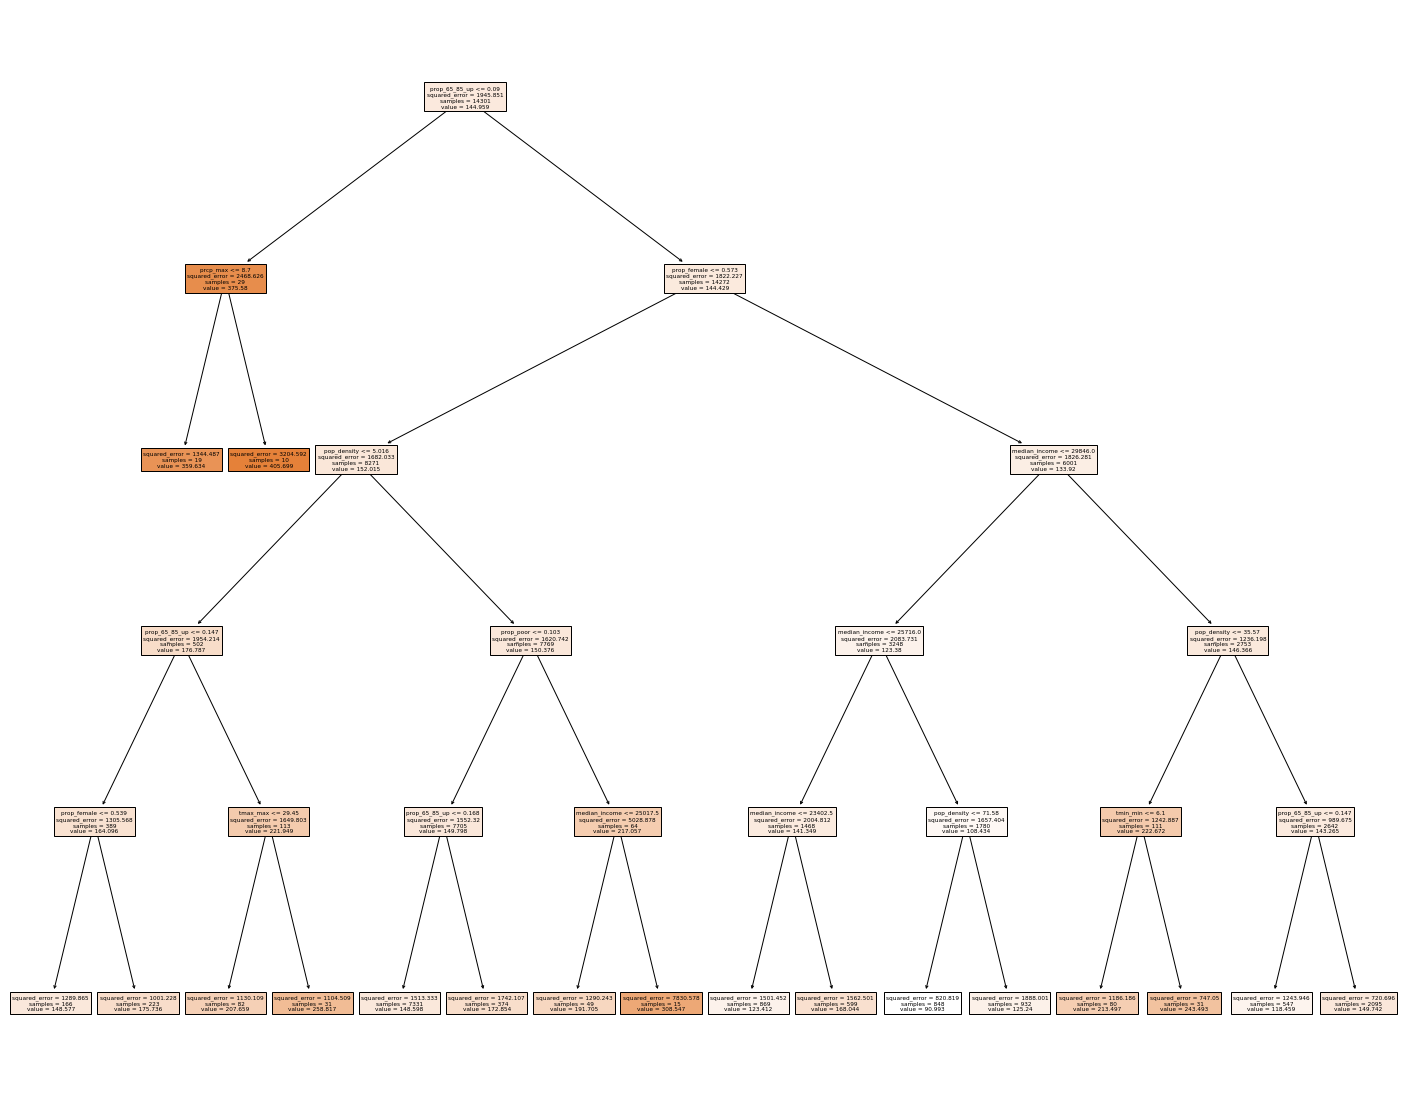

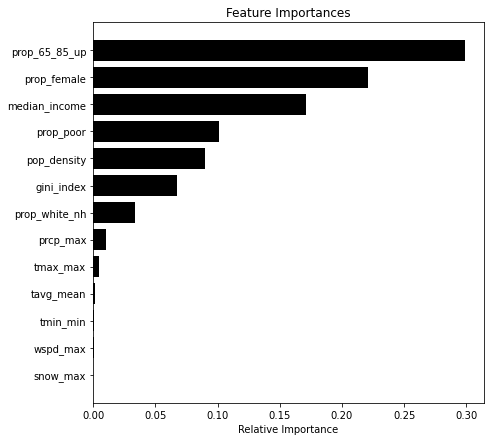

In [1045]:
#Northeast Full 
northeast_full_results = train_test_split(northeast_resampled, full_vars, [])
northeast_full_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', northeast_full_results[0], northeast_full_results[1], northeast_full_results[2], northeast_full_results[3] )